# Search: Solving a Maze Using a Goal-based Agent

Student Name: HÀ LÝ GIA BẢO

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: [your initials]

## Learning Outcomes

* Formulate search problems using key components like initial state, actions, and goal state in a deterministic, fully observable environment.
* Implement and compare search algorithms including BFS, DFS, GBFS, A*, and IDS for pathfinding in mazes.
* Analyze algorithm performance by measuring path cost, node expansions, depth, and memory usage across various maze types.
* Use visualization tools to represent maze paths and support debugging and analysis.

## Instructions

Total Points: Undergrads 100 + 5 bonus / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the notebook file and the completely rendered notebook with all outputs as a HTML file.


## Introduction

The agent must use a map it is given to plan a path through the maze from the starting location $S$ to the goal location $G$. This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the path and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and can be executed using a model-based reflex agent
that ignores all percepts and just follows the plan. We do not implement it in this exercise.

Given that the agent has a complete and correct map, the environment is **fully observable, discrete, deterministic, and known.**
Remember:

* **Fully observable** means that the agent can see its state and what the available actions are. That means the **percepts contain the complete current state.**
Here, during planning, the agent always sees its x and y coordinates on the map and
also seeks when it has reached the goal state.
* **Discrete** means that we have a **finite set of states.** The maze has a finite set
of squares the agent can be in.
* **Deterministic** means that the **transition function contains no randomness.** An action in a state will always produce the same result. Going south from the start state always will lead to the same square.
* **Know** means that the agent **knows the complete transition function.** The
agent has the map and therefore knows how its position changes when it walks in a direction.

Tree search algorithm implementations that you find online typically come from data structures courses and have a different aim than AI tree search. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root note to the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible.

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [ ]:
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



**Note:** If you get an error here that the file cannot be found, then you need to download it. See [HOWTO Work on Assignments.](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/working_on_assignments.md)

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`.

In [ ]:
import maze_helper as mh

maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


A helper function to visualize the maze is also available.

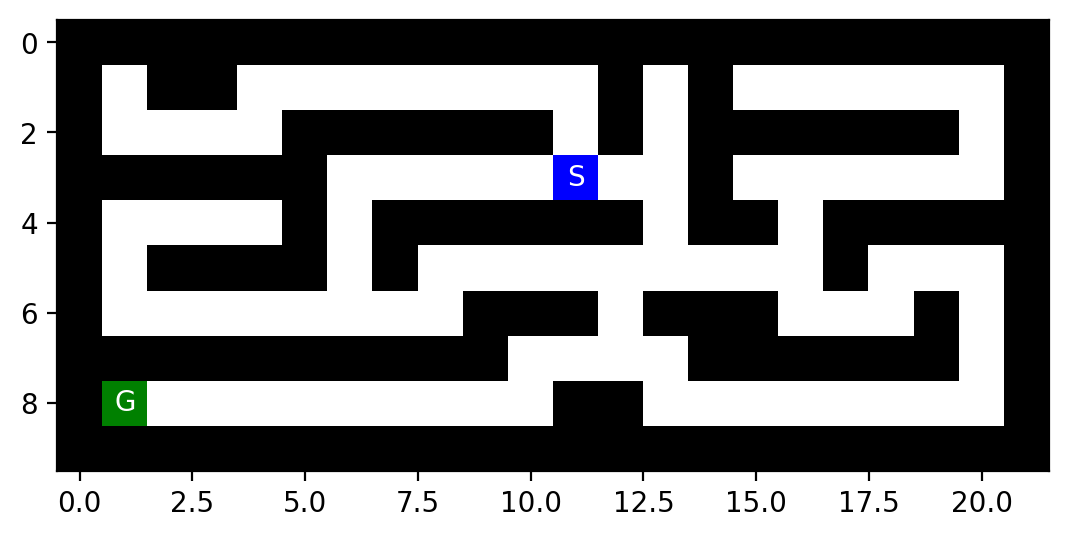

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebooks

mh.show_maze(maze)

Find the `(x,y)` position of the start and the goal using the helper function `find_pos()`

In [ ]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))

Start location: (np.int64(3), np.int64(11))
Goal location: (np.int64(8), np.int64(1))


Helper function documentation.

In [ ]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage:
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    animate_maze(result, repeat=False)
        Build an animation from a list of mazes. Assumes that results has the elements:
        path, reached, actions and maze_anim with a list of maze arrays.

    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one.
        Caution: there is no error checking!

        Parameters:
        maze: a array with characters prodced by parse_maze()
        what: the letter to be found ('S' for start and 'G' for goal)

        Returns:
        a tupple (x, y) for the found position.

    look(maze, pos)
        Look at the label of a square with the position as an array of the form (x, y).

    maze_to_matrix(maze)
        convert a maze a numeric numpy array for visualization via imshow.

    parse_maze(maze_str)
        Co

You will need to make a local copy of the module file [maze_helper.py](maze_helper.py) in the same folder where your notebook is.

## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [ ]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"

    # Bổ sung phương thức so sánh (__lt__ cho "less than") vào lớp Node
    def __lt__(self, other):
        """Phương thức so sánh cần thiết cho heapq."""
        return self.cost < other.cost

    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]

        while not node.parent is None:
            node = node.parent
            path.append(node)

        path.reverse()

        return(path)

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../HOWTOs/trees.ipynb).

# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the
    - [small maze](small_maze.txt),
    - [medium maze](medium_maze.txt),
    - [large maze](large_maze.txt),
    - [open maze](open_maze.txt),
    - [wall maze](wall_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty 2_maze](empty_2_maze.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## General [10 Points]

1. Make sure that you use the latest version of this notebook.
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formatted professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your submitted file is readable and contains all figures.
4. Document your code. Use comments in the code and add a discussion of how your implementation works and your design choices.

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate.

*Note:* You can swich the next block from code to Markdown and use formating.

In [ ]:
# Your answer goes here

---

Initial state (Trạng thái ban đầu): Vị trí của ô S trong mê cung, được biểu diễn dưới dạng một tuple (hàng, cột).

Actions (Hành động): Từ một ô bất kỳ, agent có thể di chuyển đến các ô trống kề cạnh. Các hành động có thể là: Lên (Up), Xuống (Down), Trái (Left), Phải (Right).

Transition model (Mô hình chuyển đổi): Result(s, a) → s'. Khi thực hiện một hành động a tại trạng thái s, agent sẽ chuyển sang trạng thái mới s'. Ví dụ, nếu agent ở vị trí (hàng, cột) và thực hiện hành động Phải, trạng thái mới sẽ là (hàng, cột + 1), miễn là ô đó không phải là tường (X).

Goal state (Trạng thái đích): Vị trí của ô G trong mê cung.

Path cost (Chi phí đường đi): Mỗi bước di chuyển từ ô này sang ô khác có chi phí là 1. Do đó, chi phí của một đường đi chính là độ dài của đường đi đó (tổng số bước di chuyển).

---

Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determin these values for a given maze.

In [ ]:
# Your answer goes here

---

n (kích thước không gian trạng thái): Là tổng số ô trống trong mê cung mà agent có thể đi vào. Nó được tính bằng tổng số ô không phải là tường (X).

b (hệ số rẽ nhánh tối đa - maximum branching factor): Là số lượng hành động tối đa có thể thực hiện từ một trạng thái bất kỳ. Trong mê cung này, một ô có thể có tối đa 4 ô kề cạnh (lên, xuống, trái, phải), vì vậy b=4.

d (độ sâu của lời giải tối ưu - depth of the optimal solution): Là chi phí đường đi (số bước) của đường đi ngắn nhất từ S đến G.

m (độ sâu tối đa của cây - maximum depth of tree): Là độ dài của đường đi dài nhất trong không gian trạng thái. Trong một mê cung có vòng lặp (cycles), m có thể là vô hạn nếu không có cơ chế kiểm tra chu trình (cycle checking).

---

## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

Read the following **important notes** carefully:
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and **do not store information in the map.** Only store information in the tree created during search, and use the `reached` and `frontier` data structures where appropriate.
* DSF behavior can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, this would be a big mistake since it combines the bad space complexity of BFS with the bad time complexity of DFS! **To take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure (often also called `visited` or `explored`) and by releasing the memory for nodes that are not needed anymore.**
* Since the proper implementation of DFS does not use a `reached` data structure, redundant path checking abilities are limited to cycle checking.
You need to implement **cycle checking since DSF is incomplete (produces an infinite loop) if cycles cannot be prevented.** You will see in your experiments that cycle checking in open spaces is challenging.

In [ ]:
# Your code goes here
from collections import deque
import maze_helper as mh
import numpy as np
import heapq
import pandas as pd
import time

def breadth_first_search(maze, timeout=None):
    """Sử dụng thuật toán tìm kiếm theo chiều rộng (BFS)."""
    start_pos = mh.find_pos(maze, 'S')
    goal_pos = mh.find_pos(maze, 'G')
    start_time = time.time()

    # Node ban đầu
    start_node = Node(pos=start_pos, parent=None, action=None, cost=0)

    # Frontier sử dụng hàng đợi (deque)
    frontier = deque([start_node])
    reached = {start_node.pos}

    # Biến thống kê
    nodes_expanded = 0
    max_tree_depth = 0
    max_frontier_size = 1

    # Bắt đầu tìm kiếm
    while frontier:
        if timeout and (time.time() - start_time) > timeout:
            return None
        max_frontier_size = max(max_frontier_size, len(frontier))

        # Lấy node từ đầu hàng đợi
        node = frontier.popleft()
        nodes_expanded += 1

        # Cập nhật độ sâu tối đa
        max_tree_depth = max(max_tree_depth, node.cost)

        # Kiểm tra xem có phải là đích không
        if node.pos == goal_pos:
            return {
                "solution_node": node,
                "nodes_expanded": nodes_expanded,
                "max_tree_depth": max_tree_depth,
                "max_frontier_size": max_frontier_size,
                "max_nodes_in_memory": len(reached) + len(frontier)
            }

        # Mở rộng các node con
        for action, pos in get_neighbors(maze, node.pos):
            if pos not in reached:
                child = Node(pos=pos, parent=node, action=action, cost=node.cost + 1)
                frontier.append(child)
                reached.add(pos)

    return None # Không tìm thấy lời giải

def get_neighbors(maze, pos):
    """Hàm trợ giúp để lấy các ô hàng xóm hợp lệ."""
    row, col = pos
    neighbors = []
    # Các hành động có thể: Lên, Xuống, Trái, Phải
    actions = [('Up', (-1, 0)), ('Down', (1, 0)), ('Left', (0, -1)), ('Right', (0, 1))]
    for action, (dr, dc) in actions:
        new_row, new_col = row + dr, col + dc
        if 0 <= new_row < maze.shape[0] and 0 <= new_col < maze.shape[1] and maze[new_row, new_col] != 'X':
            neighbors.append((action, (new_row, new_col)))
    return neighbors

def depth_first_search(maze, timeout=None):
    """Sử dụng thuật toán tìm kiếm theo chiều sâu (DFS) với kiểm tra chu trình."""
    start_pos = mh.find_pos(maze, 'S')
    goal_pos = mh.find_pos(maze, 'G')
    start_time = time.time()

    start_node = Node(pos=start_pos, parent=None, action=None, cost=0)

    # Frontier sử dụng ngăn xếp (stack)
    frontier = [start_node]

    # Biến thống kê
    nodes_expanded = 0
    max_tree_depth = 0
    max_frontier_size = 1

    while frontier:
        if timeout and (time.time() - start_time) > timeout:
            return None
        max_frontier_size = max(max_frontier_size, len(frontier))

        # Lấy node từ đỉnh ngăn xếp
        node = frontier.pop()
        nodes_expanded += 1

        max_tree_depth = max(max_tree_depth, node.cost)

        if node.pos == goal_pos:
            path = node.get_path_from_root()
            return {
                "solution_node": node,
                "nodes_expanded": nodes_expanded,
                "max_tree_depth": max_tree_depth,
                "max_frontier_size": max_frontier_size,
                "max_nodes_in_memory": len(path) + len(frontier) # Chỉ lưu trữ đường đi hiện tại và frontier
            }

        # Cycle checking: Kiểm tra xem node con đã tồn tại trên đường đi chưa
        path_to_current = {n.pos for n in node.get_path_from_root()}

        for action, pos in get_neighbors(maze, node.pos):
            if pos not in path_to_current:
                child = Node(pos=pos, parent=node, action=action, cost=node.cost + 1)
                frontier.append(child)

    return None

How does BFS and DFS (without a reached data structure) deal with loops (cycles)?

In [ ]:
# Discussion

---

BFS: Sử dụng một danh sách reached (hoặc visited) để lưu trữ tất cả các trạng thái đã được khám phá. Khi mở rộng một nút, BFS sẽ không thêm các hàng xóm đã có trong reached vào frontier. Điều này giúp BFS tránh được các vòng lặp một cách tự nhiên và hiệu quả.

DFS: Triển khai DFS tiết kiệm bộ nhớ không sử dụng reached. Do đó, nó có nguy cơ bị kẹt trong vòng lặp vô hạn. Để ngăn chặn điều này, chúng ta phải thực hiện kiểm tra chu trình (cycle checking). Tức là, trước khi thêm một nút con vào frontier, ta phải kiểm tra xem trạng thái của nó đã tồn tại trên đường đi từ gốc đến nút cha hiện tại hay chưa.

---

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations? Especially discuss the difference in space complexity between BFS and DFS.

In [ ]:
# Discussion

---

**Tính hoàn chỉnh (completeness) và tối ưu (optimality):**

BFS: Hoàn chỉnh (nếu không gian trạng thái hữu hạn, nó luôn tìm thấy lời giải nếu có). Tối ưu (nếu chi phí mỗi bước là như nhau, nó luôn tìm thấy đường đi ngắn nhất).

DFS (với cycle checking): Hoàn chỉnh (vì kiểm tra chu trình ngăn nó lặp vô hạn trong không gian hữu hạn). Không tối ưu (nó có thể tìm thấy một lời giải dài hơn trước khi tìm thấy lời giải ngắn nhất).

**Độ phức tạp thời gian và không gian:**

BFS:

Thời gian: O(b^d), vì nó phải duyệt qua tất cả các nút ở mỗi độ sâu.

Không gian: O(b^d), vì nó phải lưu trữ tất cả các nút trong frontier ở độ sâu d. Đây là nhược điểm lớn nhất của BFS.

DFS:

Thời gian: O(b^m), trong trường hợp xấu nhất nó có thể phải duyệt toàn bộ cây tìm kiếm.

Không gian: O(b⋅m), vì nó chỉ cần lưu trữ đường đi hiện tại và các nút anh em chưa được khám phá. Đây là ưu điểm lớn của DFS so với BFS.

---

## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides).

In [ ]:
# Your code goes here
def manhattan_distance(pos1, pos2):
    """Tính khoảng cách Manhattan giữa hai điểm."""
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

def a_star_search(maze, heuristic_func, timeout=None):
    """Sử dụng thuật toán A*."""
    start_pos = mh.find_pos(maze, 'S')
    goal_pos = mh.find_pos(maze, 'G')
    start_time = time.time()

    start_node = Node(pos=start_pos, parent=None, action=None, cost=0)

    # Frontier là một hàng đợi ưu tiên (min-heap)
    # (priority, node)
    frontier = [(0, start_node)]
    reached = {start_node.pos: 0} # Lưu trữ chi phí tốt nhất đến mỗi vị trí

    nodes_expanded = 0
    max_tree_depth = 0
    max_frontier_size = 1

    while frontier:
        if timeout and (time.time() - start_time) > timeout:
            return None
        max_frontier_size = max(max_frontier_size, len(frontier))

        # Lấy node có f(n) thấp nhất
        priority, node = heapq.heappop(frontier)

        # Nếu đã có đường đi tốt hơn đến vị trí này, bỏ qua
        if node.cost > reached[node.pos]:
            continue

        nodes_expanded += 1
        max_tree_depth = max(max_tree_depth, node.cost)

        if node.pos == goal_pos:
            return {
                "solution_node": node,
                "nodes_expanded": nodes_expanded,
                "max_tree_depth": max_tree_depth,
                "max_frontier_size": max_frontier_size,
                "max_nodes_in_memory": len(reached) + len(frontier)
            }

        for action, pos in get_neighbors(maze, node.pos):
            new_cost = node.cost + 1
            if pos not in reached or new_cost < reached[pos]:
                reached[pos] = new_cost
                priority = new_cost + heuristic_func(pos, goal_pos)
                child = Node(pos=pos, parent=node, action=action, cost=new_cost)
                heapq.heappush(frontier, (priority, child))

    return None

def greedy_best_first_search(maze, heuristic_func, timeout=None):
    """Sử dụng thuật toán Greedy Best-First Search."""
    start_pos = mh.find_pos(maze, 'S')
    goal_pos = mh.find_pos(maze, 'G')
    start_time = time.time()

    start_node = Node(pos=start_pos, parent=None, action=None, cost=0)

    # Frontier là hàng đợi ưu tiên, sắp xếp theo heuristic
    frontier = [(heuristic_func(start_pos, goal_pos), start_node)]
    reached = {start_node.pos}

    nodes_expanded = 0
    max_tree_depth = 0
    max_frontier_size = 1

    while frontier:
        if timeout and (time.time() - start_time) > timeout:
            return None
        max_frontier_size = max(max_frontier_size, len(frontier))

        priority, node = heapq.heappop(frontier)

        nodes_expanded += 1
        max_tree_depth = max(max_tree_depth, node.cost)

        if node.pos == goal_pos:
            return {
                "solution_node": node,
                "nodes_expanded": nodes_expanded,
                "max_tree_depth": max_tree_depth,
                "max_frontier_size": max_frontier_size,
                "max_nodes_in_memory": len(reached) + len(frontier)
            }

        for action, pos in get_neighbors(maze, node.pos):
            if pos not in reached:
                reached.add(pos)
                priority = heuristic_func(pos, goal_pos)
                child = Node(pos=pos, parent=node, action=action, cost=node.cost + 1)
                heapq.heappush(frontier, (priority, child))

    return None

Are your implementations complete and optimal? What is the time and space complexity?

In [ ]:
# Discussion

**Tính hoàn chỉnh và tối ưu:**

GBFS: Hoàn chỉnh trong không gian trạng thái hữu hạn (nhờ reached), nhưng không tối ưu. Nó có thể đi theo một đường có vẻ "gần" đích nhưng thực tế lại dài và tốn kém hơn.

A*: Hoàn chỉnh. Tối ưu miễn là hàm heuristic là admissible (không bao giờ đánh giá quá cao chi phí thực tế đến đích). Khoảng cách Manhattan là một heuristic admissible cho bài toán này.

**Độ phức tạp thời gian và không gian:**

Cả hai thuật toán trong trường hợp xấu nhất có thể phải duyệt toàn bộ không gian trạng thái, nên độ phức tạp cả về thời gian và không gian là O(∣V∣+∣E∣) hay O(b^d), tương tự như BFS. Tuy nhiên, với một heuristic tốt, A* thường hiệu quả hơn rất nhiều so với các thuật toán không thông tin.

## Task 4: Comparison and discussion [20 Points]

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug (likely your frontier and cycle checking for DFS are the issue). If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

--- Solving: small_maze.txt ---

Solution for BFS:


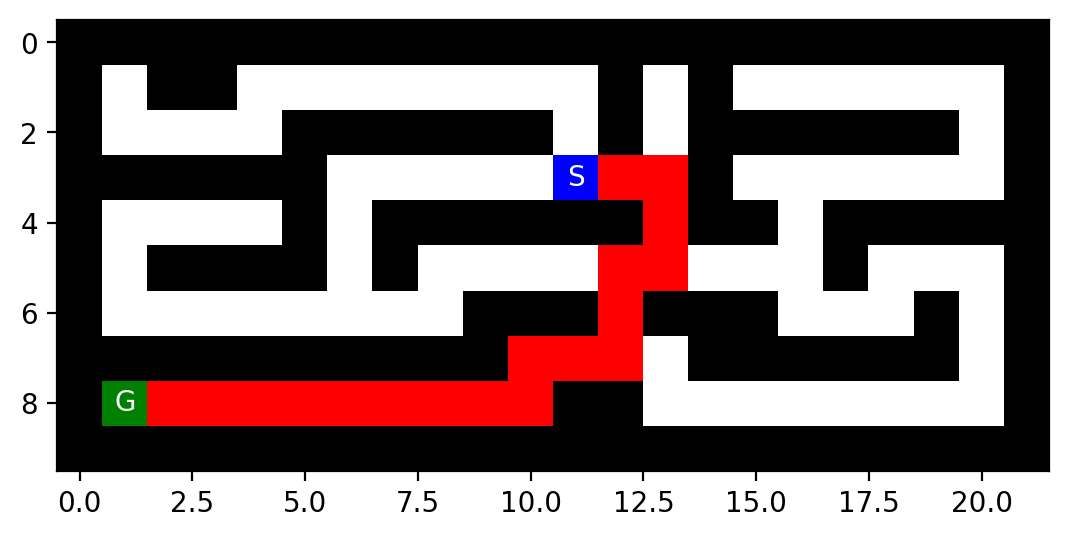


Solution for DFS:


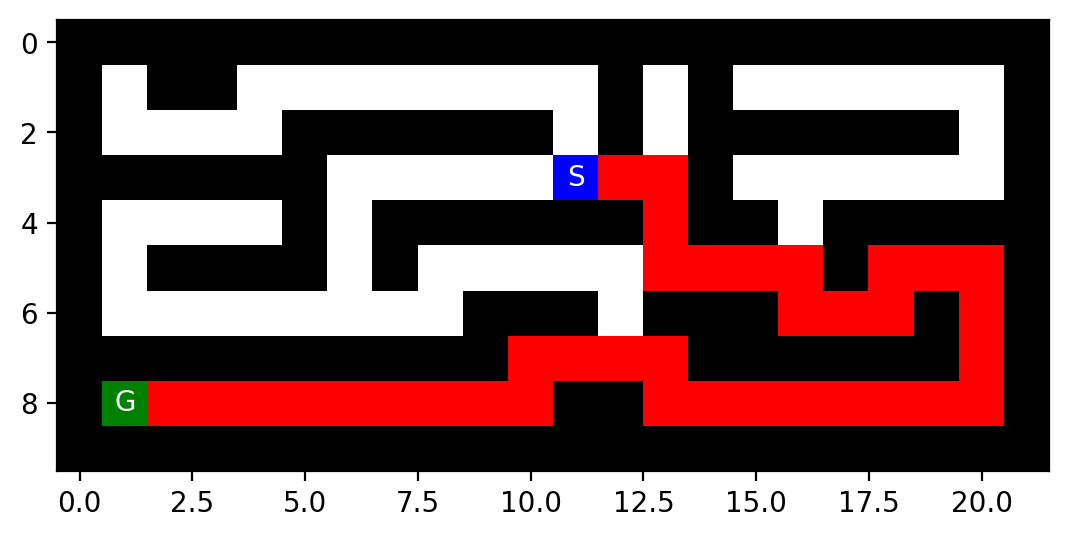


Solution for Greedy BFS:


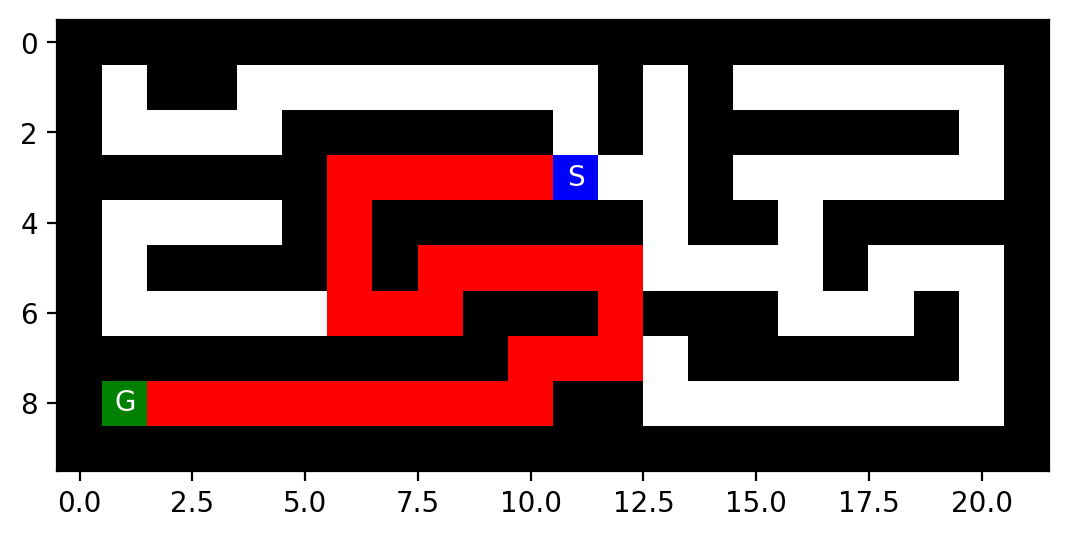


Solution for A* Search:


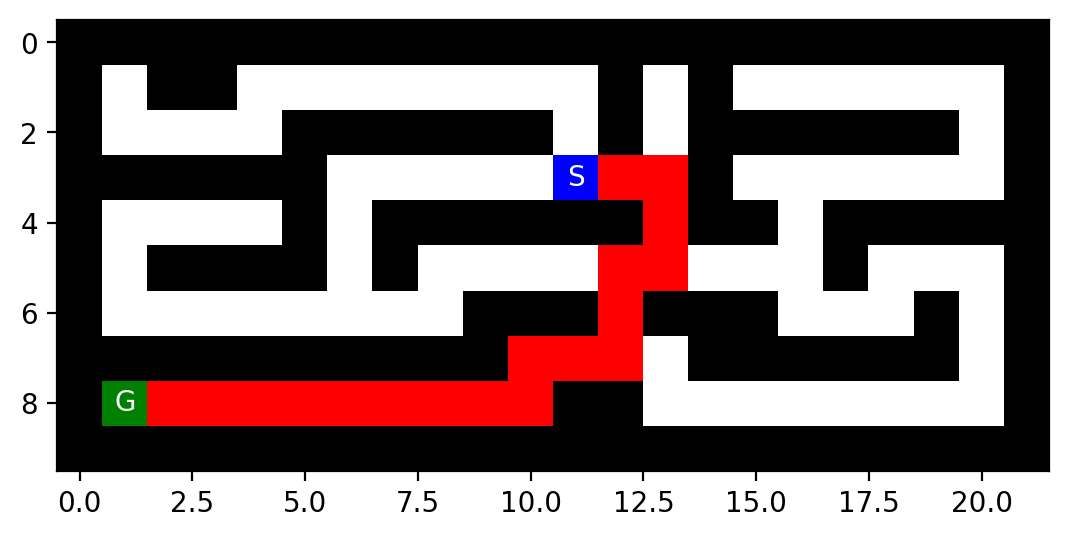

--- Solving: medium_maze.txt ---

Solution for BFS:


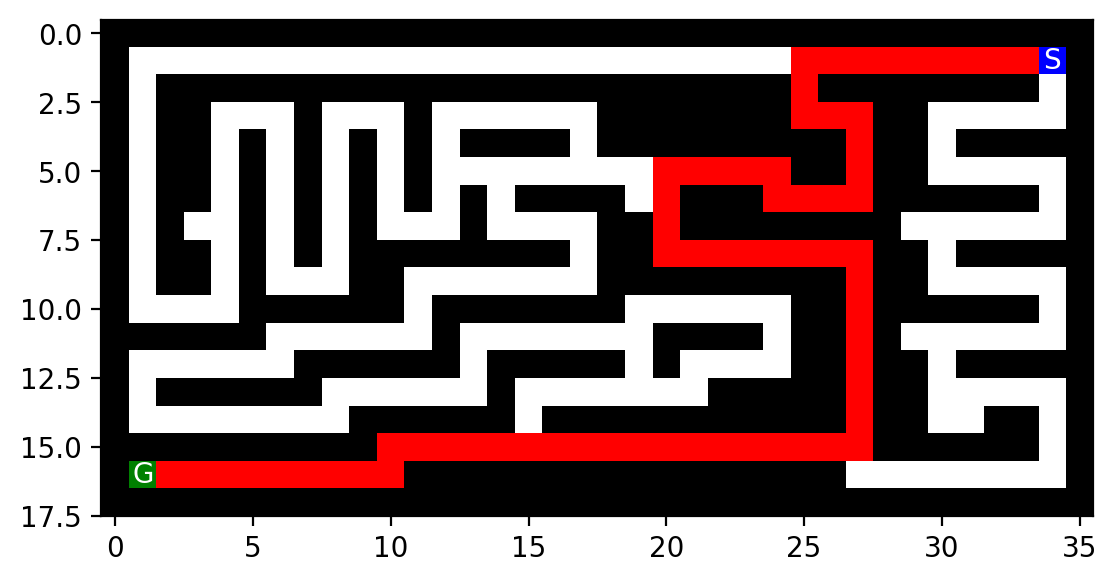


Solution for DFS:


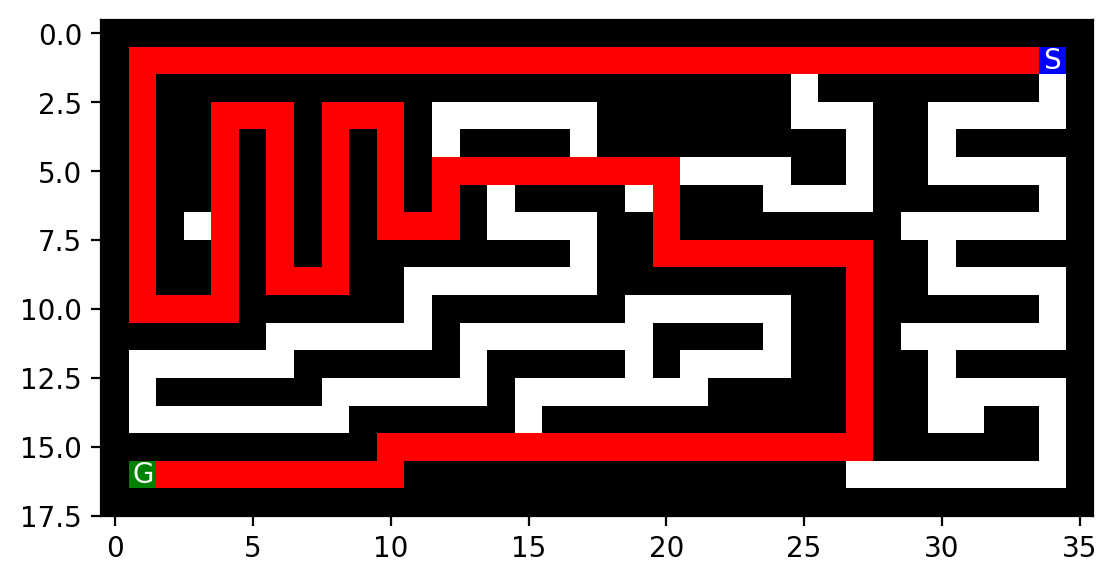


Solution for Greedy BFS:


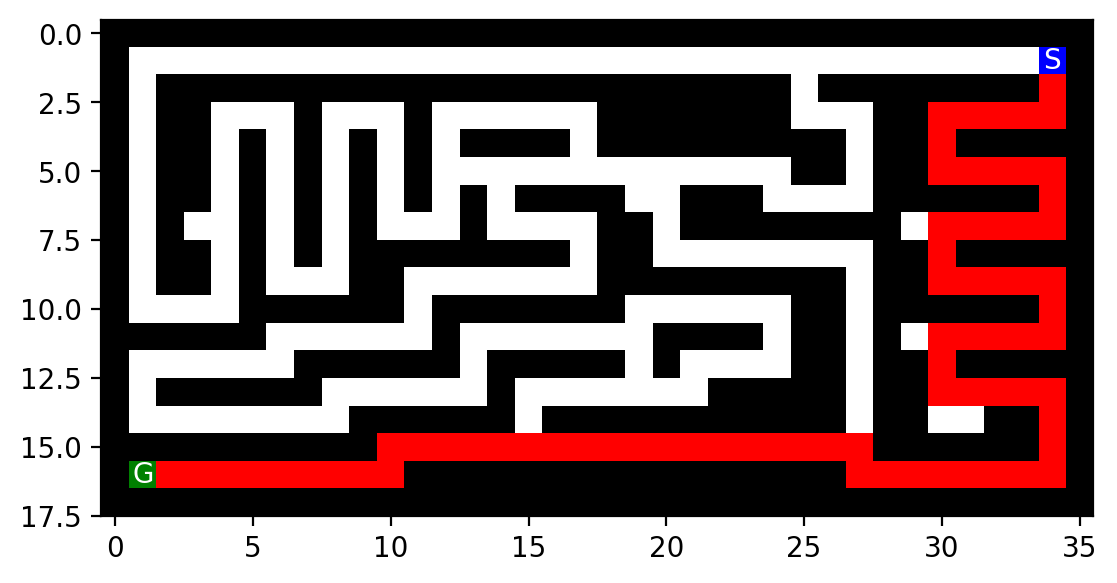


Solution for A* Search:


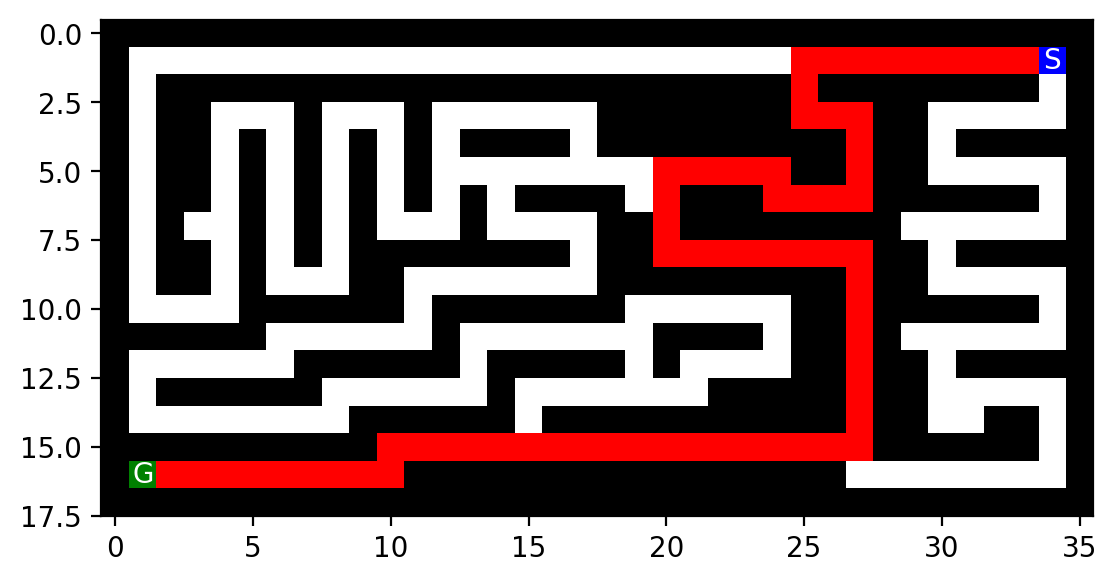

--- Solving: large_maze.txt ---

Solution for BFS:


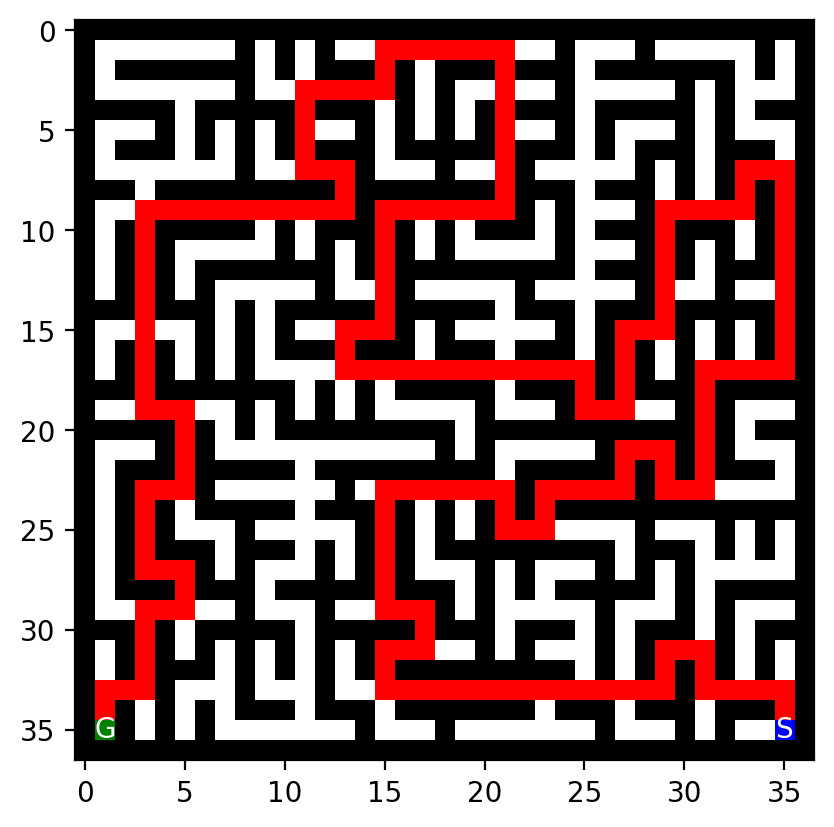


Solution for DFS:


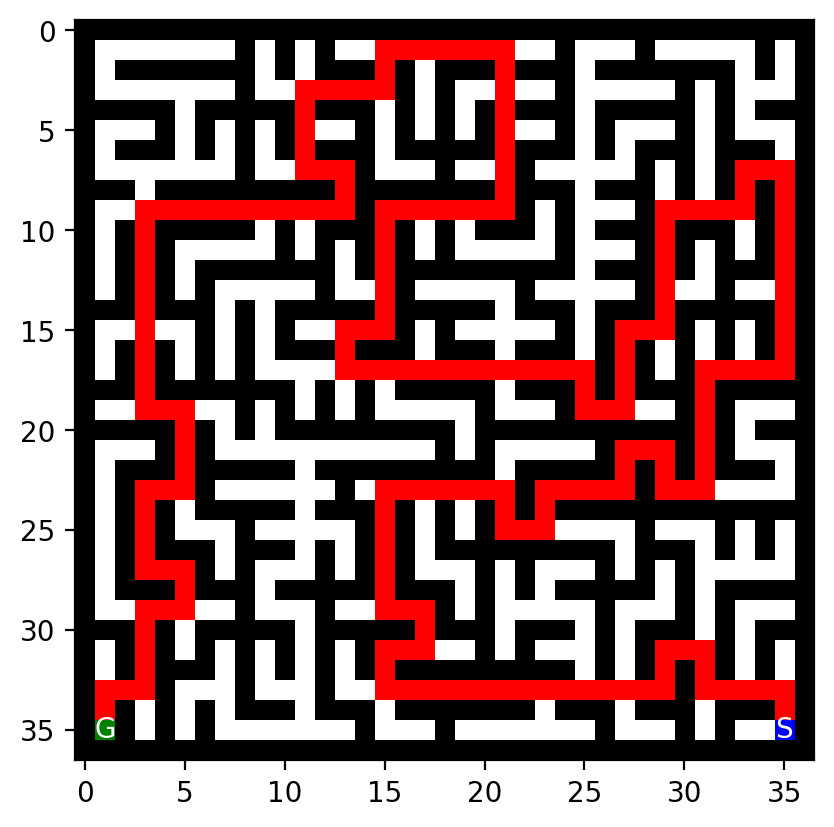


Solution for Greedy BFS:


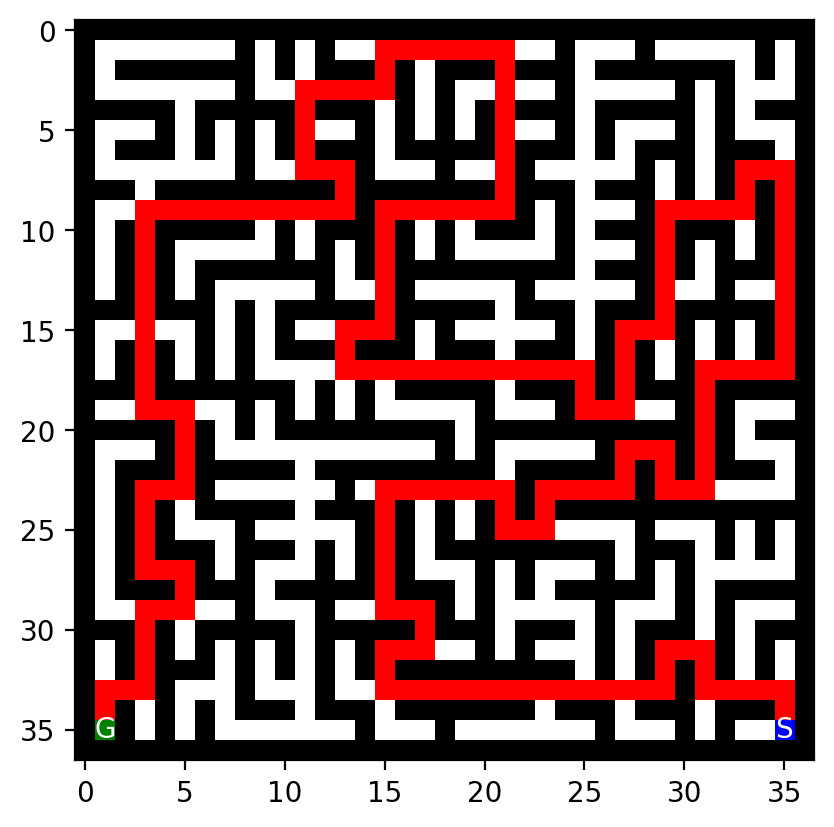


Solution for A* Search:


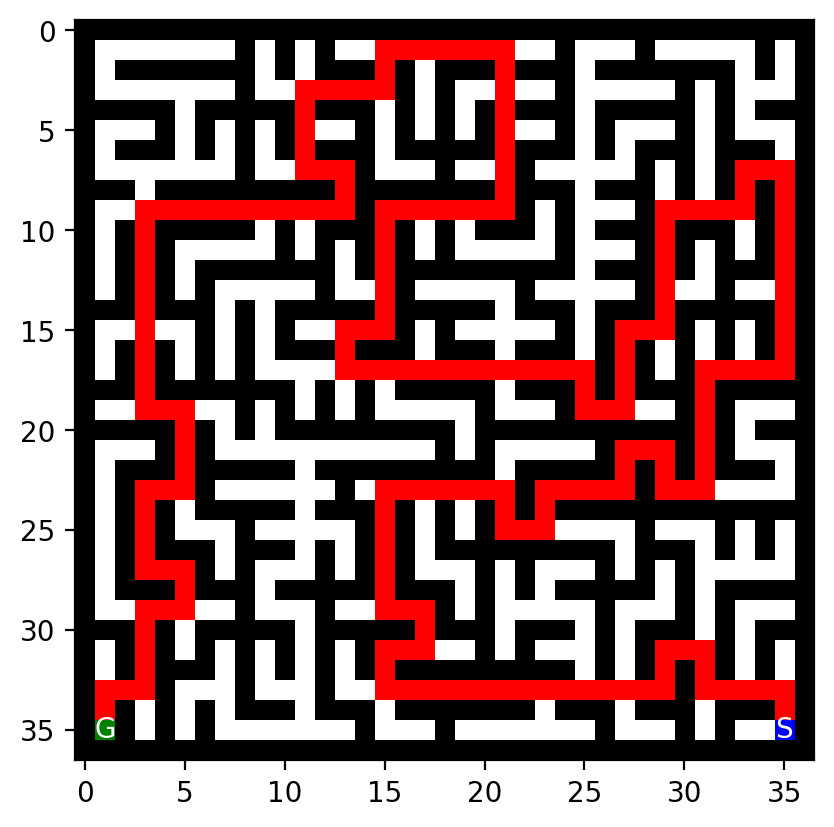

--- Solving: open_maze.txt ---

Solution for BFS:


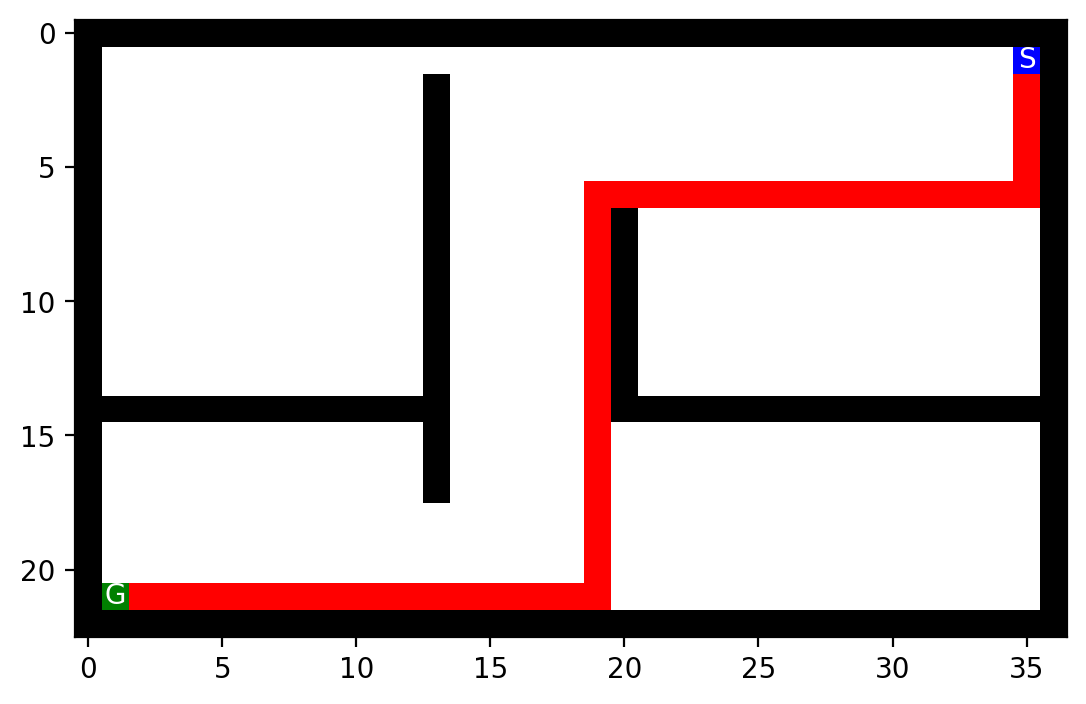


Solution for DFS: Không tìm thấy lời giải (timeout).

Solution for Greedy BFS:


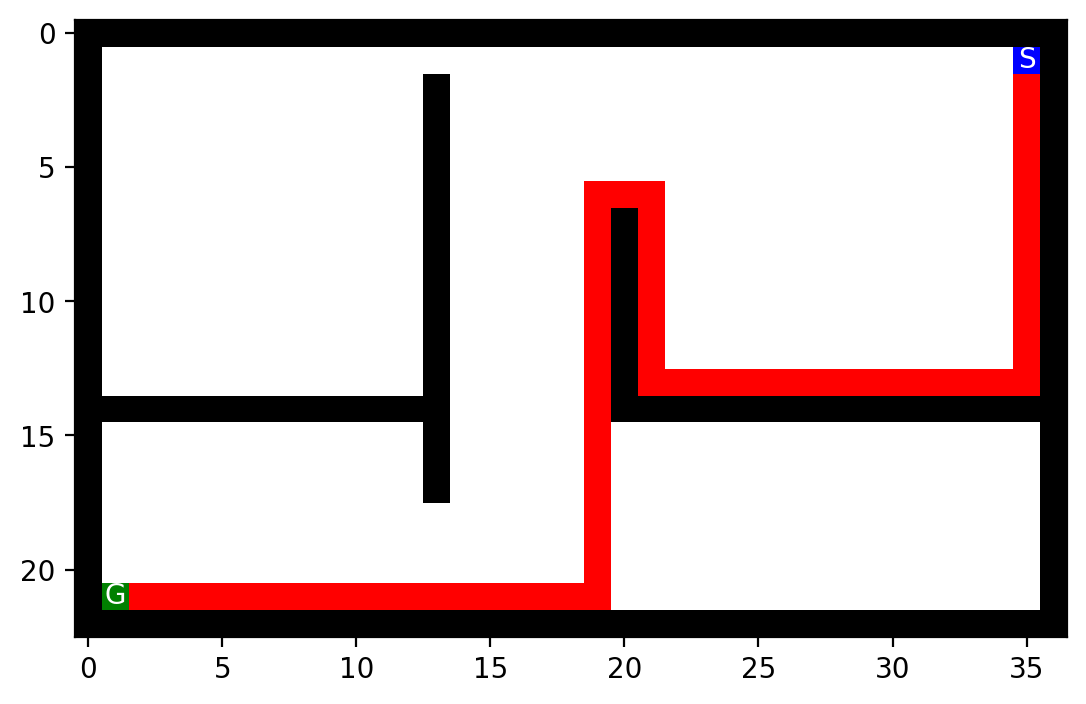


Solution for A* Search:


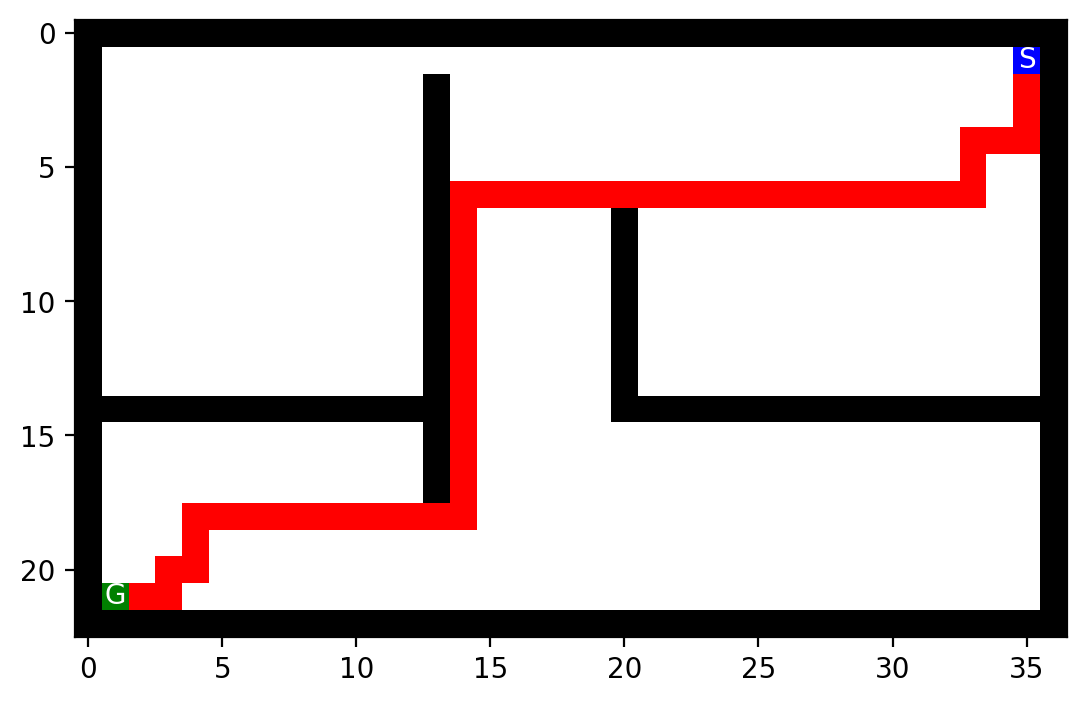

--- Solving: wall_maze.txt ---

Solution for BFS:


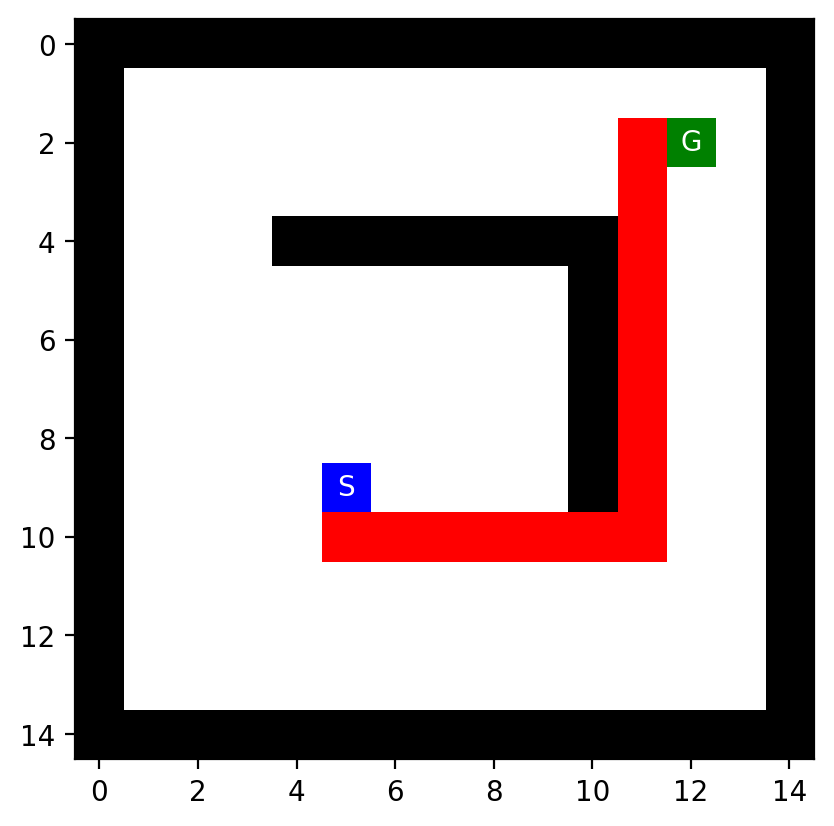


Solution for DFS:


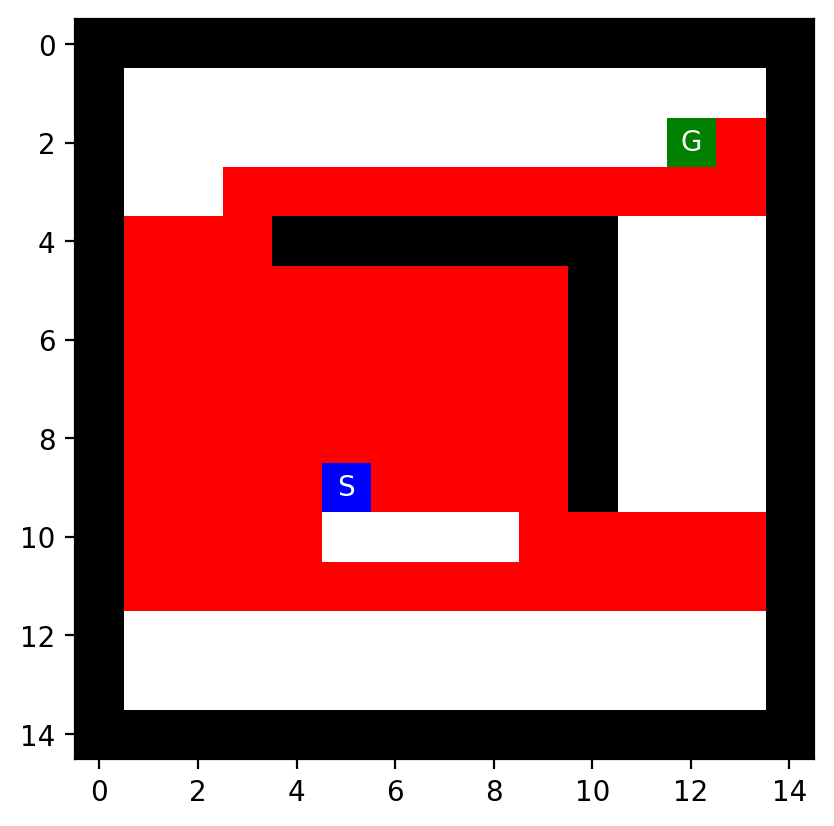


Solution for Greedy BFS:


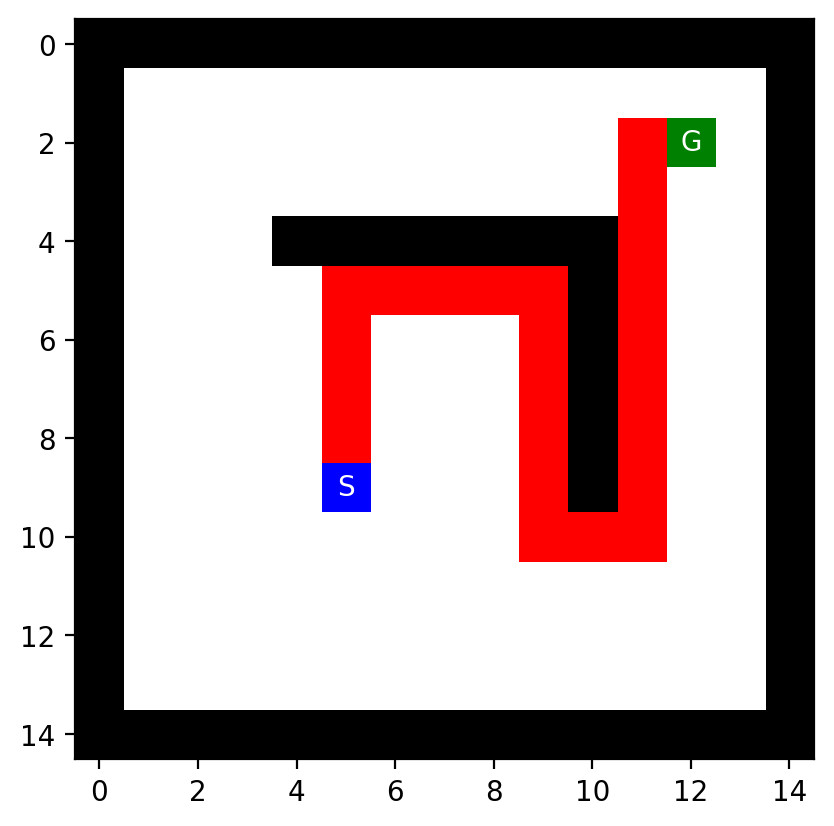


Solution for A* Search:


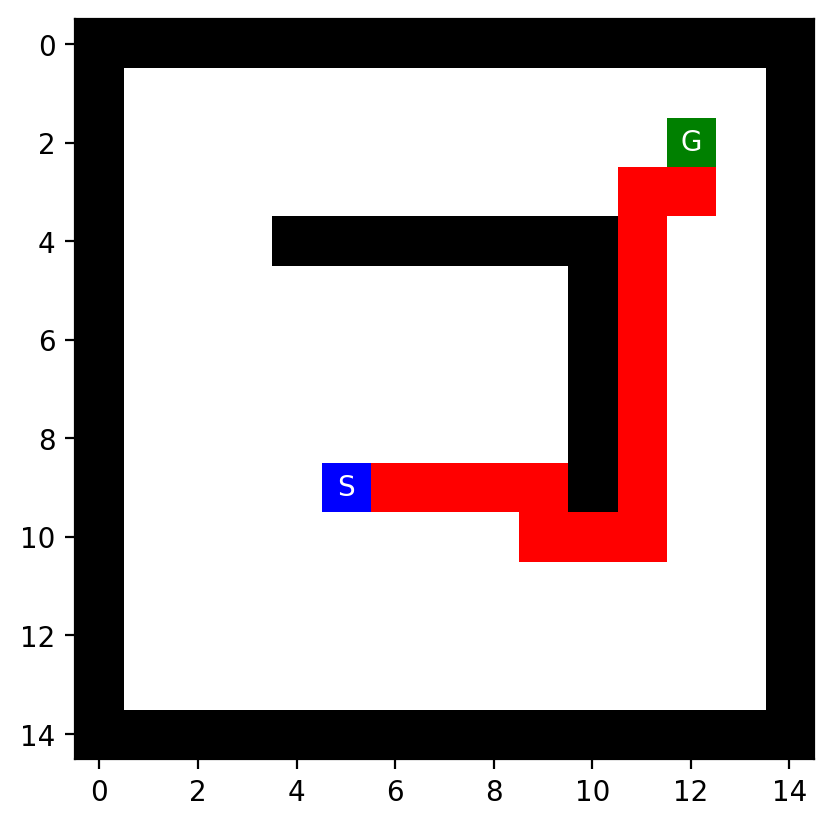

--- Solving: loops_maze.txt ---

Solution for BFS:


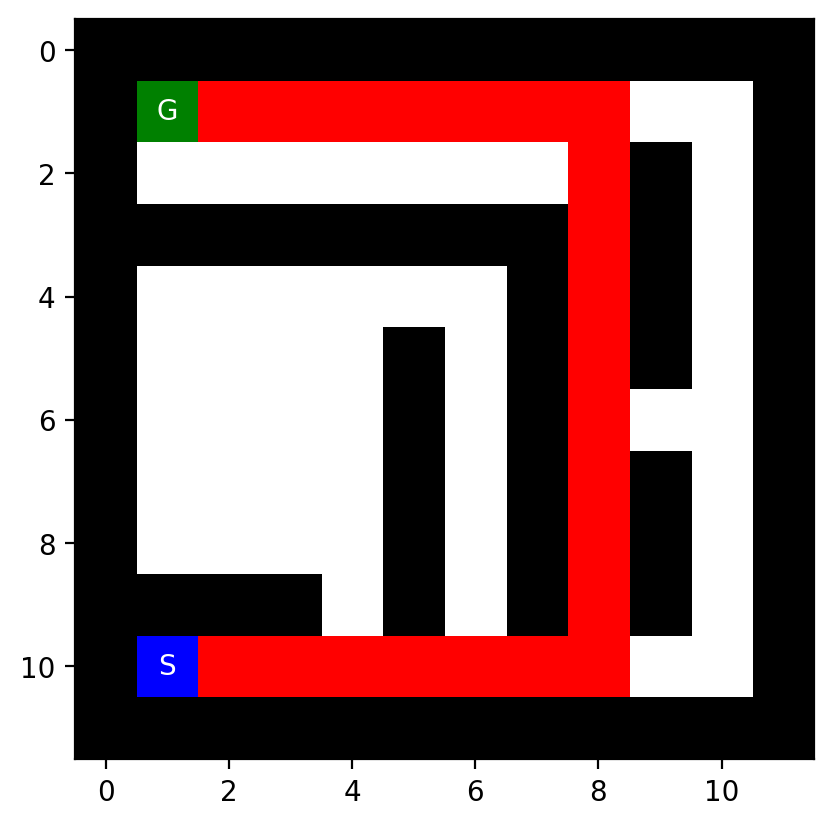


Solution for DFS:


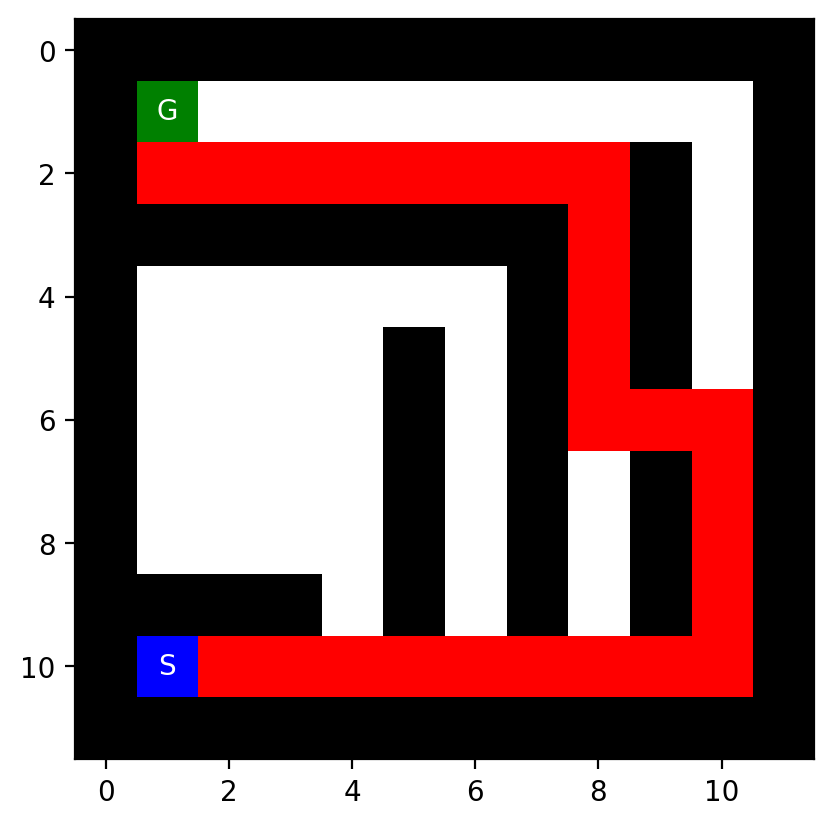


Solution for Greedy BFS:


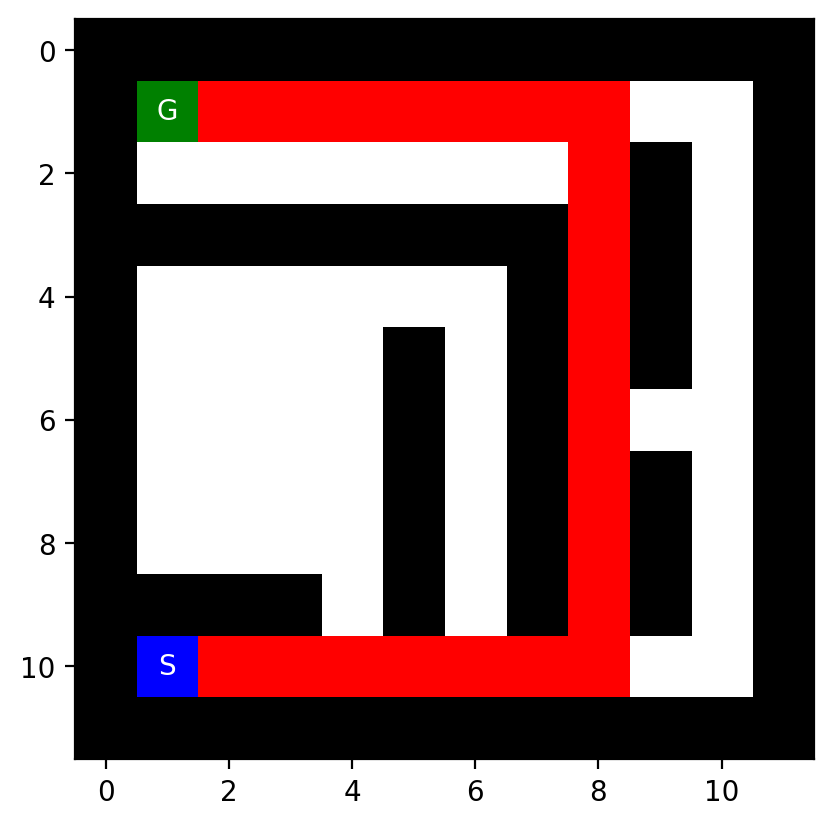


Solution for A* Search:


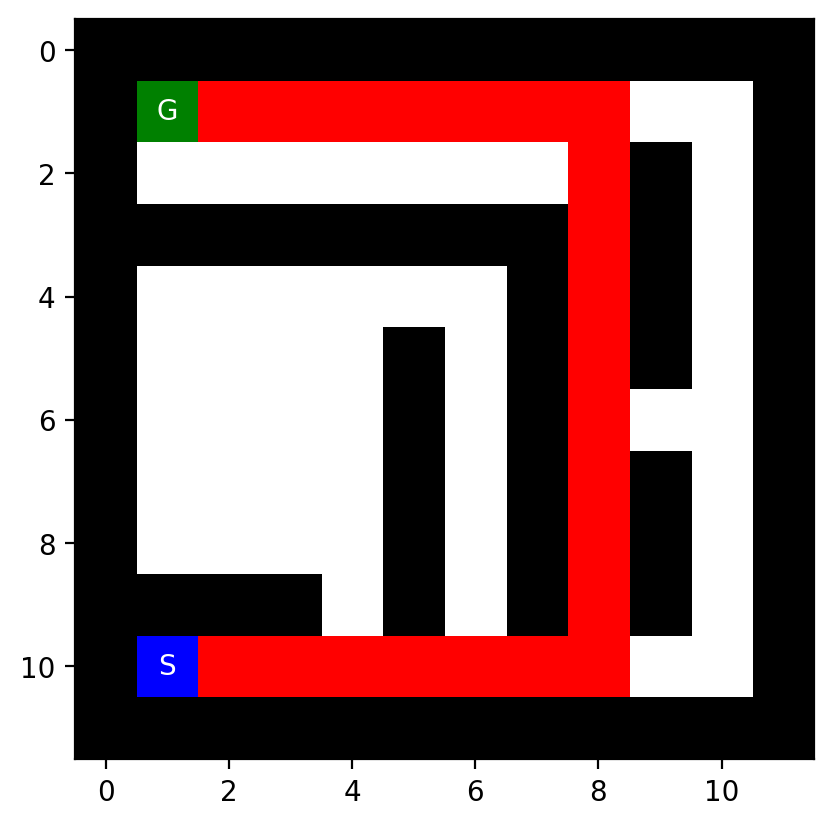

--- Solving: empty_maze.txt ---

Solution for BFS:


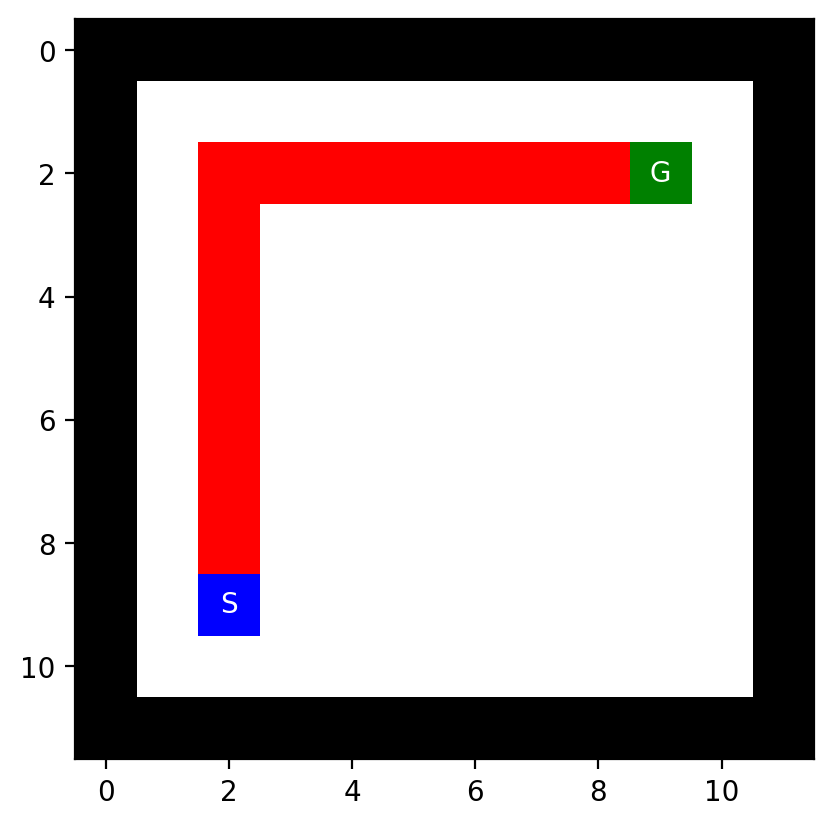


Solution for DFS:


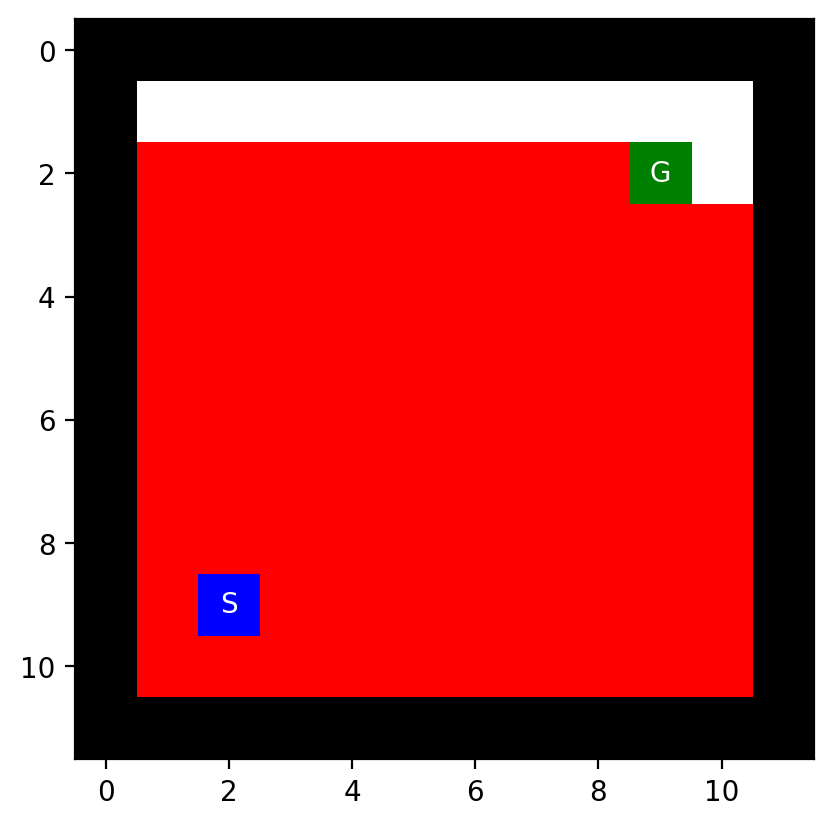


Solution for Greedy BFS:


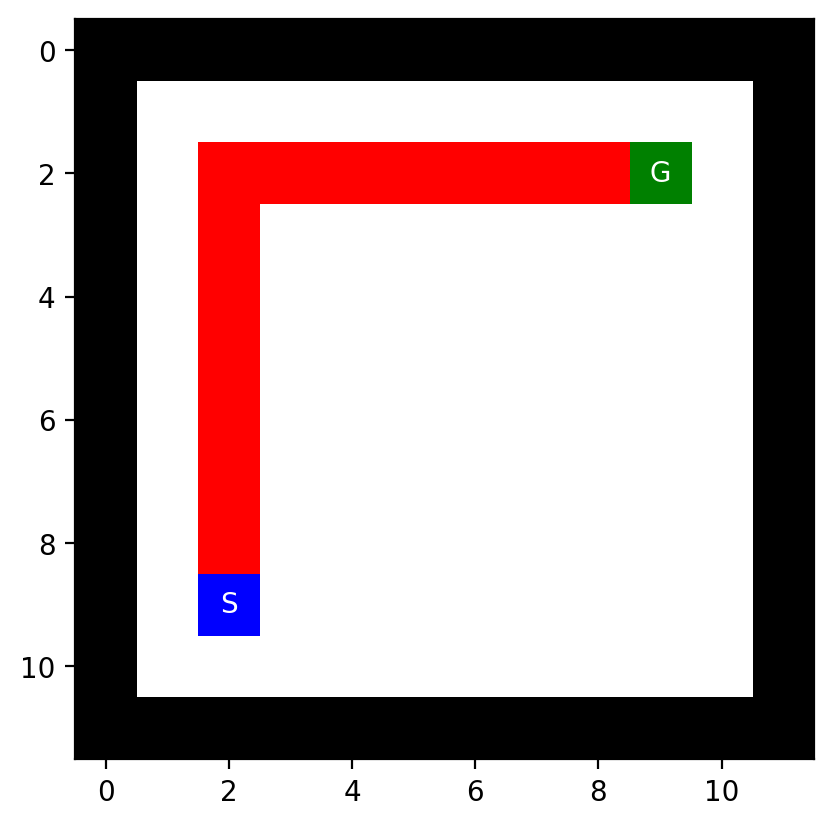


Solution for A* Search:


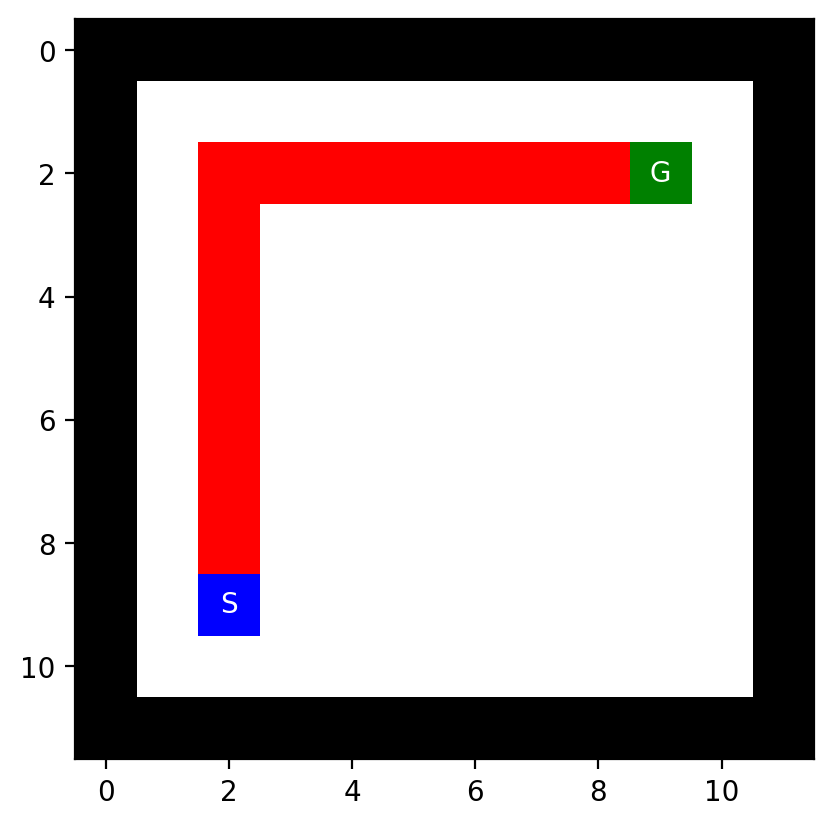

--- Solving: empty_maze_2.txt ---

Solution for BFS:


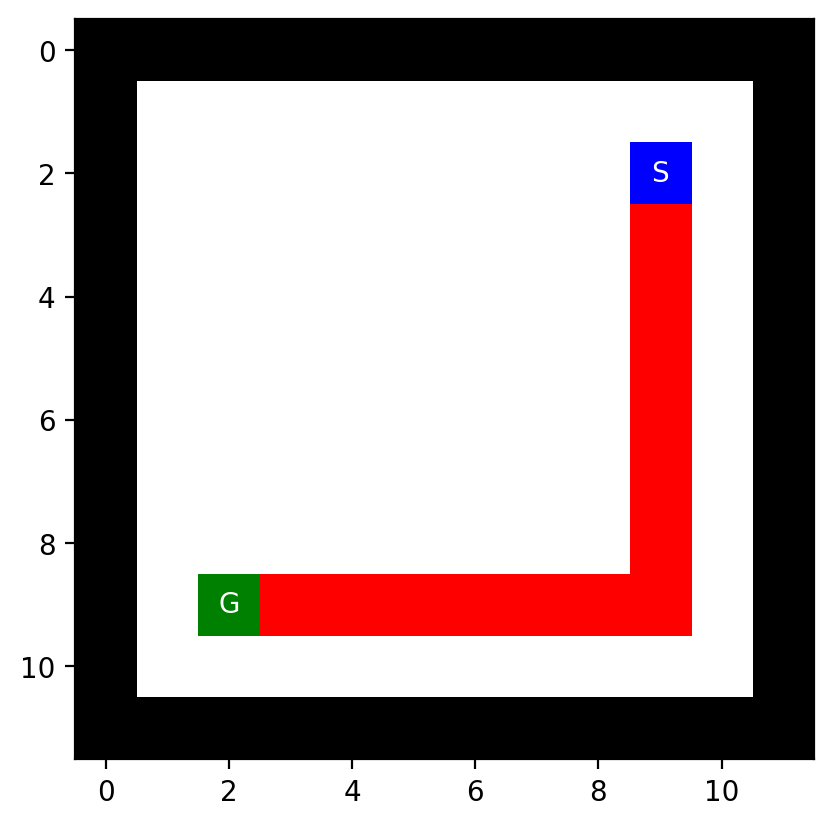


Solution for DFS:


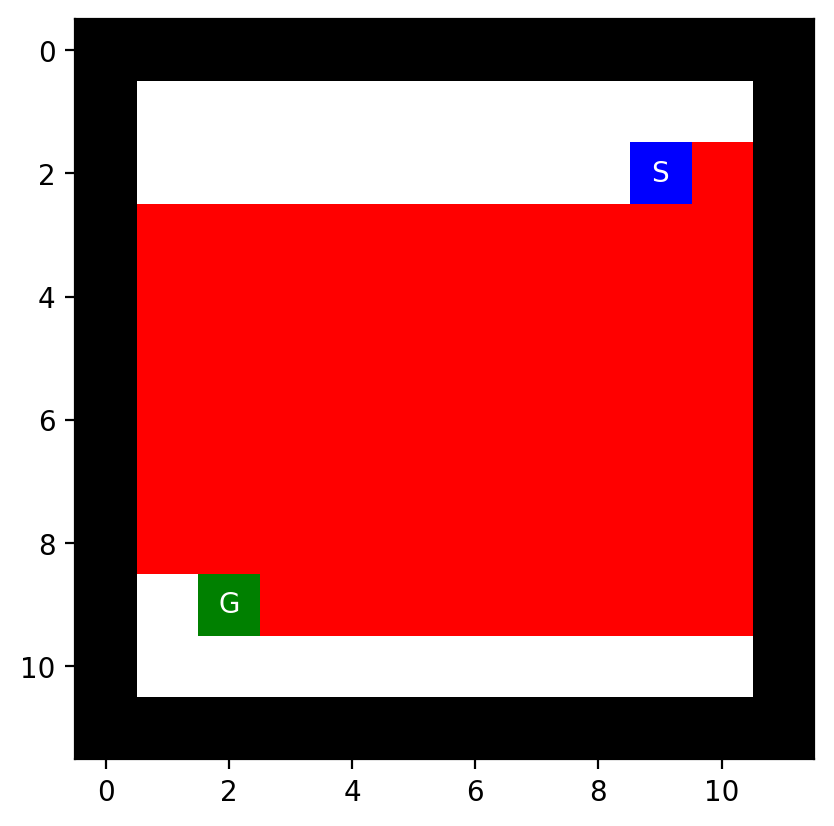


Solution for Greedy BFS:


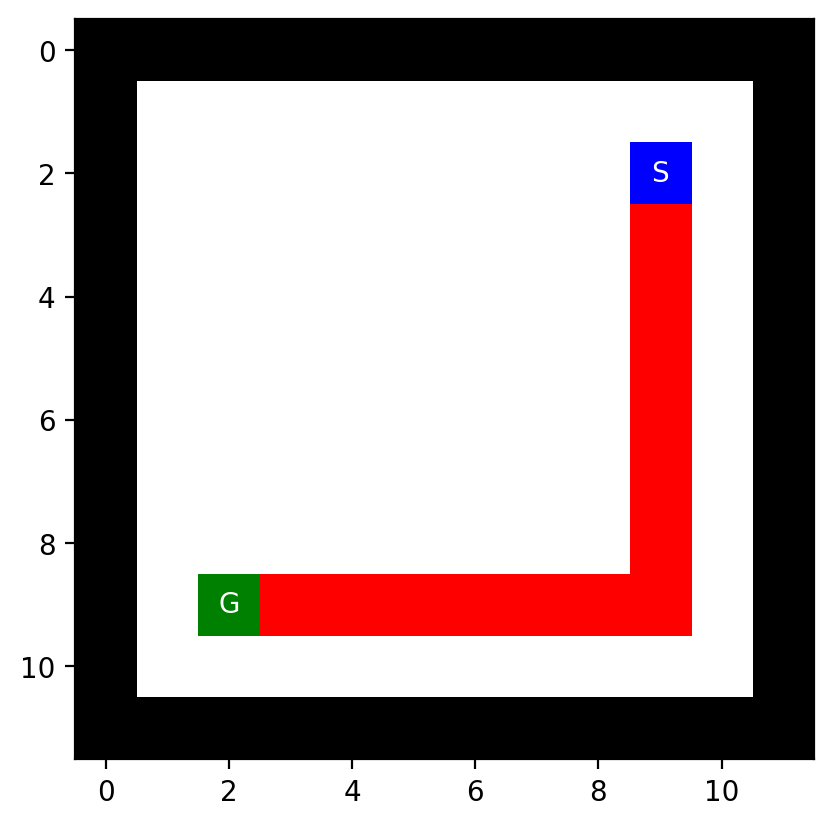


Solution for A* Search:


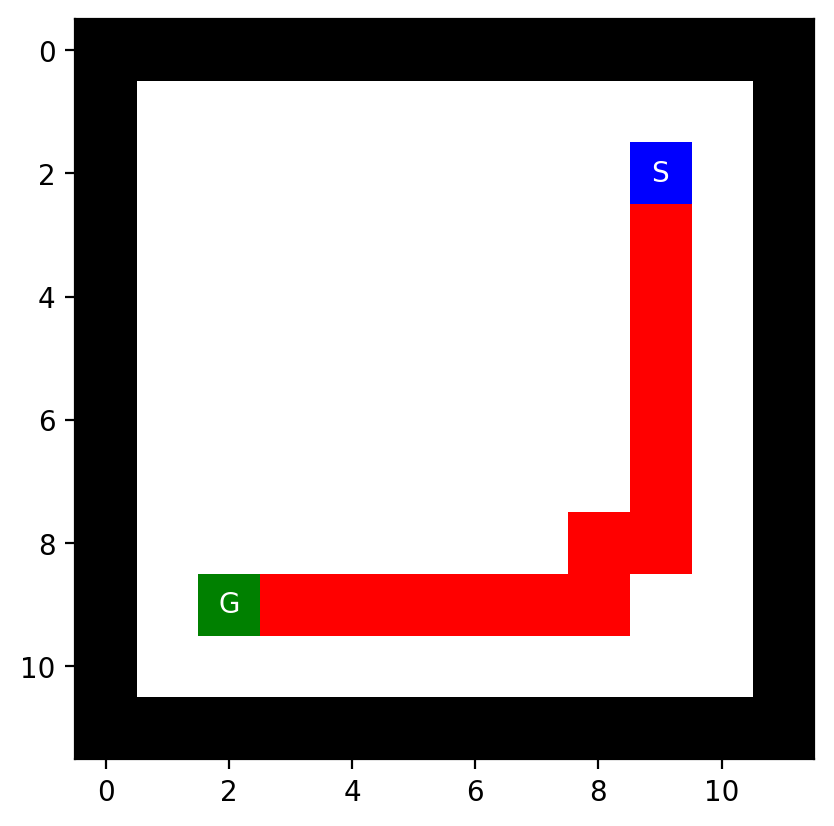


--- Results for small_maze.txt ---


,Algorithm,Path Cost,Nodes Expanded,Max Tree Depth,Max Frontier Size,Max Nodes in Memory,Time
0,BFS,19,92,19,8,94,0.0009s
1,DFS,37,38,37,7,44,0.0008s
2,Greedy BFS,29,40,29,5,48,0.0004s
3,A* Search,19,54,19,8,64,0.0005s



--- Results for medium_maze.txt ---


,Algorithm,Path Cost,Nodes Expanded,Max Tree Depth,Max Frontier Size,Max Nodes in Memory,Time
0,BFS,68,270,68,8,274,0.0033s
1,DFS,130,147,130,9,139,0.0045s
2,Greedy BFS,74,79,74,4,85,0.0009s
3,A* Search,68,222,68,8,234,0.0055s



--- Results for large_maze.txt ---


,Algorithm,Path Cost,Nodes Expanded,Max Tree Depth,Max Frontier Size,Max Nodes in Memory,Time
0,BFS,210,621,210,8,625,0.0085s
1,DFS,210,388,222,39,249,0.0135s
2,Greedy BFS,210,468,210,20,506,0.0068s
3,A* Search,210,550,210,12,564,0.0085s



--- Results for open_maze.txt ---


,Algorithm,Path Cost,Nodes Expanded,Max Tree Depth,Max Frontier Size,Max Nodes in Memory,Time
0,BFS,54,683,54,25,685,0.0136s
1,DFS,N/A,N/A,N/A,N/A,N/A,30.0005s
2,Greedy BFS,68,90,68,66,220,0.0016s
3,A* Search,54,536,54,28,574,0.0105s



--- Results for wall_maze.txt ---


,Algorithm,Path Cost,Nodes Expanded,Max Tree Depth,Max Frontier Size,Max Nodes in Memory,Time
0,BFS,16,152,16,18,158,0.0018s
1,DFS,82,28684,98,97,168,0.6255s
2,Greedy BFS,24,35,24,25,83,0.0007s
3,A* Search,16,54,16,26,104,0.0013s



--- Results for loops_maze.txt ---


,Algorithm,Path Cost,Nodes Expanded,Max Tree Depth,Max Frontier Size,Max Nodes in Memory,Time
0,BFS,23,72,23,8,72,0.0017s
1,DFS,27,31,27,12,39,0.0006s
2,Greedy BFS,23,52,23,10,70,0.0009s
3,A* Search,23,59,23,6,65,0.0009s



--- Results for empty_maze.txt ---


,Algorithm,Path Cost,Nodes Expanded,Max Tree Depth,Max Frontier Size,Max Nodes in Memory,Time
0,BFS,14,96,14,12,100,0.0011s
1,DFS,88,89,88,81,169,0.0042s
2,Greedy BFS,14,15,14,29,71,0.0005s
3,A* Search,14,64,14,31,124,0.0012s



--- Results for empty_maze_2.txt ---


,Algorithm,Path Cost,Nodes Expanded,Max Tree Depth,Max Frontier Size,Max Nodes in Memory,Time
0,BFS,14,96,14,12,100,0.0008s
1,DFS,70,71,70,75,145,0.0009s
2,Greedy BFS,14,15,14,29,71,0.0003s
3,A* Search,14,64,14,31,124,0.0007s


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


In [ ]:
# Add code

def solve_and_report(maze_files, algorithms, timeout=30):
    results = {}
    for file in maze_files:
        print(f"--- Solving: {file} ---")
        with open(file, "r") as f:
            maze = mh.parse_maze(f.read())

        maze_results = []
        for name, func in algorithms.items():
            start_time = time.time()
            if "A*" in name or "Greedy" in name:
                 result = func(maze, manhattan_distance, timeout=timeout)
            else:
                 result = func(maze, timeout=timeout)
            duration = time.time() - start_time

            if result:
                solution_node = result['solution_node']
                path_cost = solution_node.cost
                nodes_expanded = result['nodes_expanded']
                max_depth = result['max_tree_depth']
                max_frontier = result['max_frontier_size']
                max_memory = result['max_nodes_in_memory']

                maze_results.append([name, path_cost, nodes_expanded, max_depth, max_frontier, max_memory, f"{duration:.4f}s"])

                # Visualize
                path_nodes = solution_node.get_path_from_root()
                maze_viz = np.copy(maze)
                for node in path_nodes:
                    if maze_viz[node.pos] == ' ':
                        maze_viz[node.pos] = 'P'
                print(f"\nSolution for {name}:")
                mh.show_maze(maze_viz)

            else:
                maze_results.append([name, "N/A", "N/A", "N/A", "N/A", "N/A", f"{duration:.4f}s"])
                print(f"\nSolution for {name}: Không tìm thấy lời giải (timeout).")

        df = pd.DataFrame(maze_results, columns=["Algorithm", "Path Cost", "Nodes Expanded", "Max Tree Depth", "Max Frontier Size", "Max Nodes in Memory", "Time"])
        results[file] = df

    return results

maze_files = ["small_maze.txt", "medium_maze.txt", "large_maze.txt",
              "open_maze.txt", "wall_maze.txt", "loops_maze.txt",
              "empty_maze.txt", "empty_maze_2.txt"]

algorithms = {
    "BFS": breadth_first_search,
    "DFS": depth_first_search,
    "Greedy BFS": greedy_best_first_search,
    "A* Search": a_star_search
}

all_results = solve_and_report(maze_files, algorithms)

for maze_name, df in all_results.items():
    print(f"\n--- Results for {maze_name} ---")
    display(df)

%time

Complete the following table for each maze.

__Small maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |

__Medium Maze__

...

Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)).

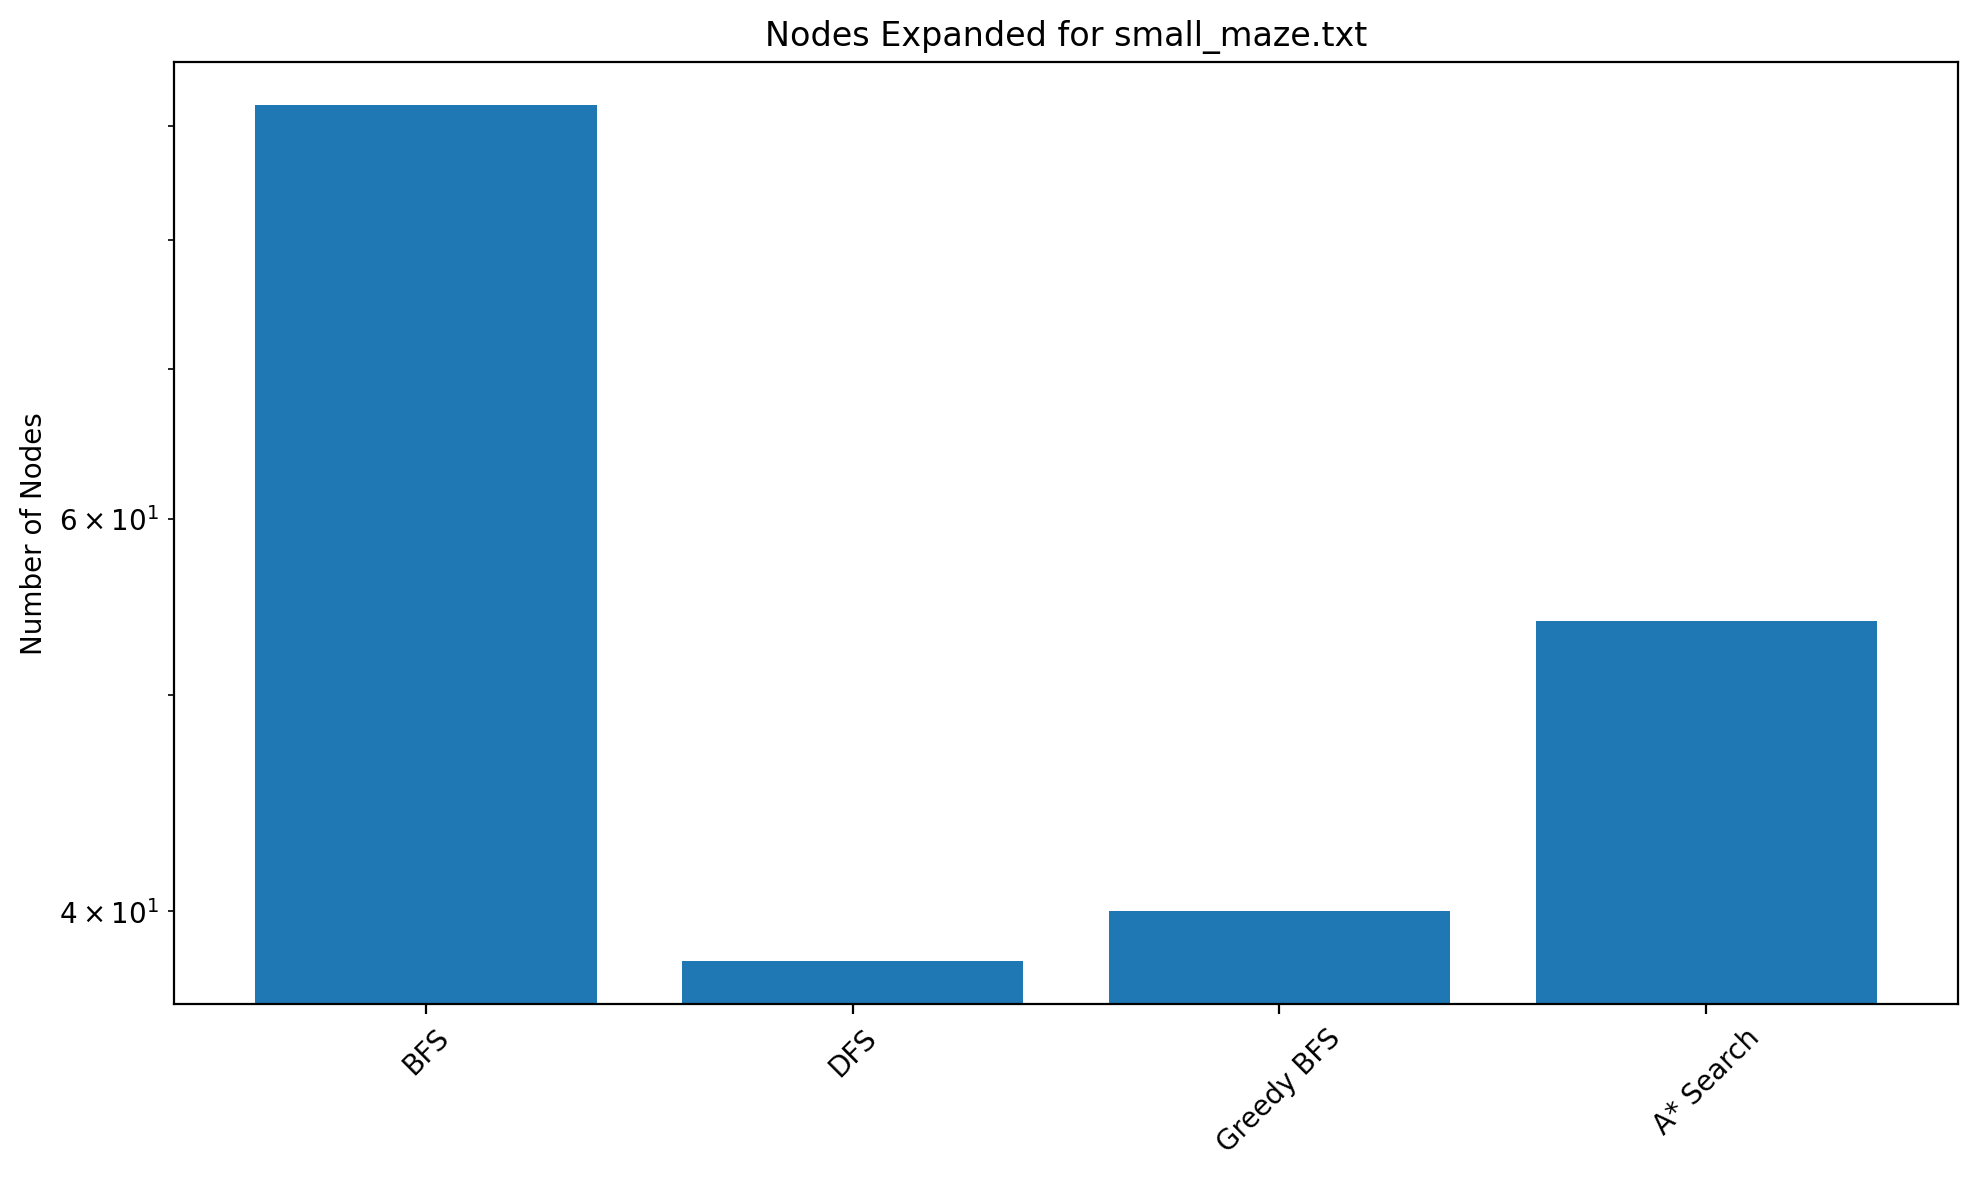

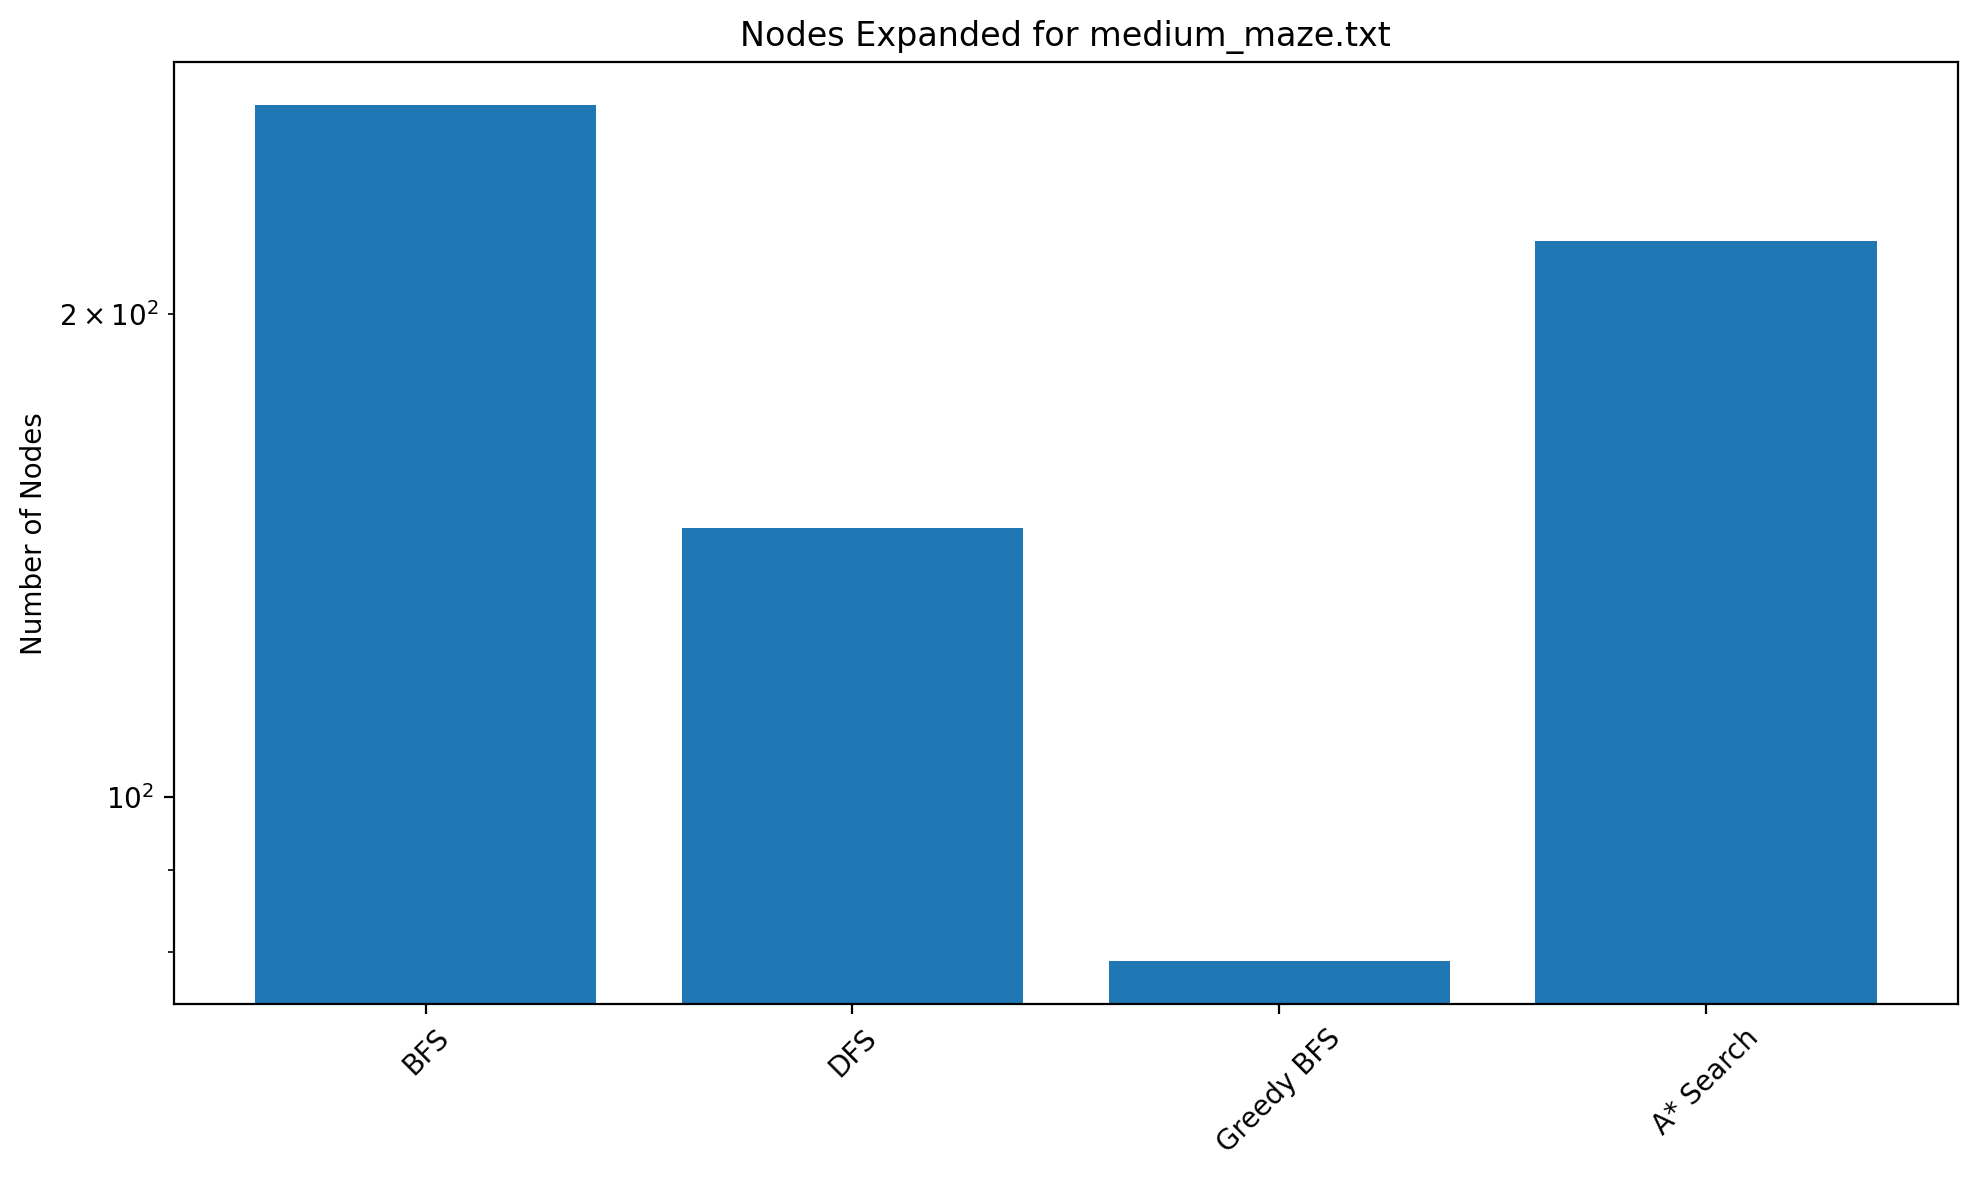

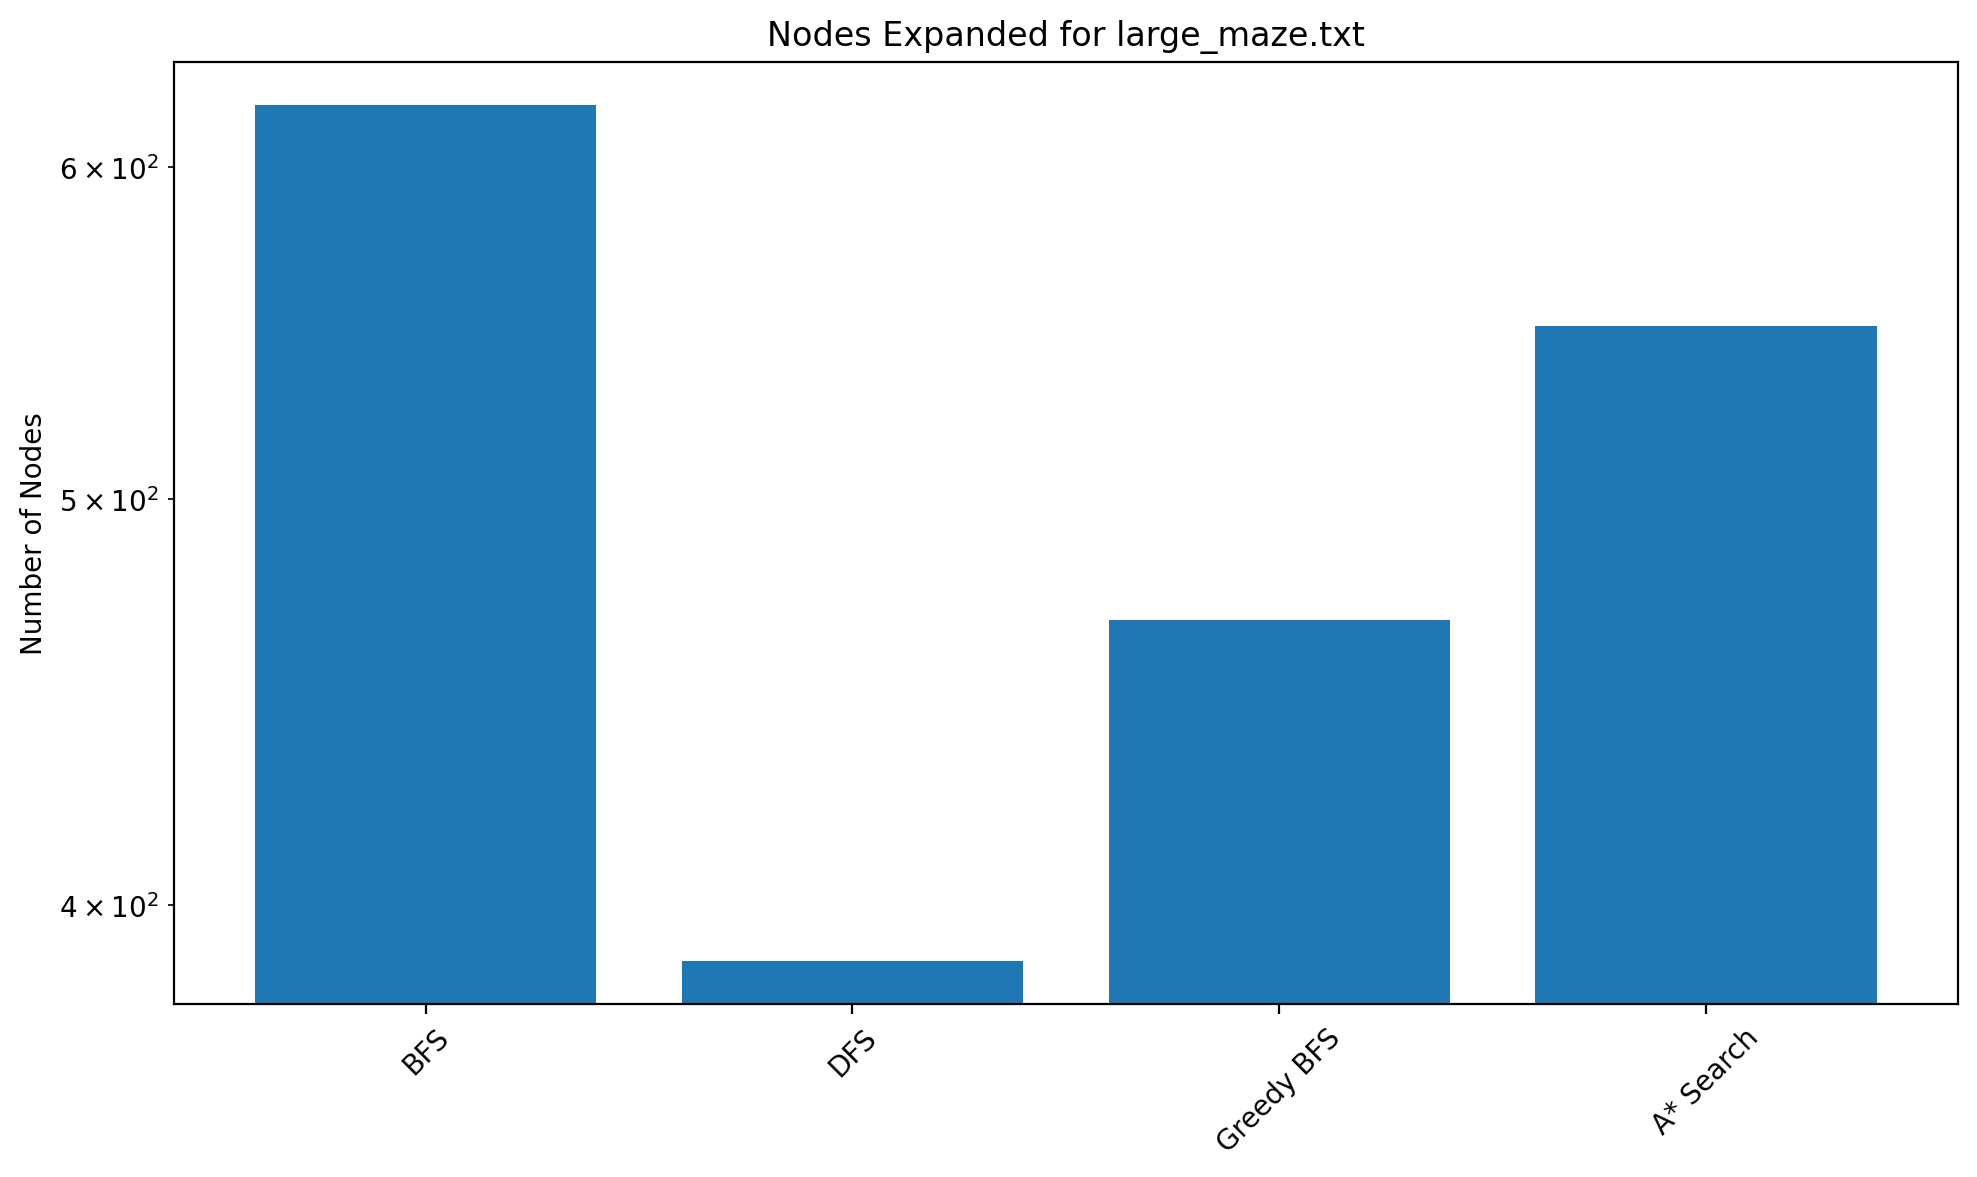

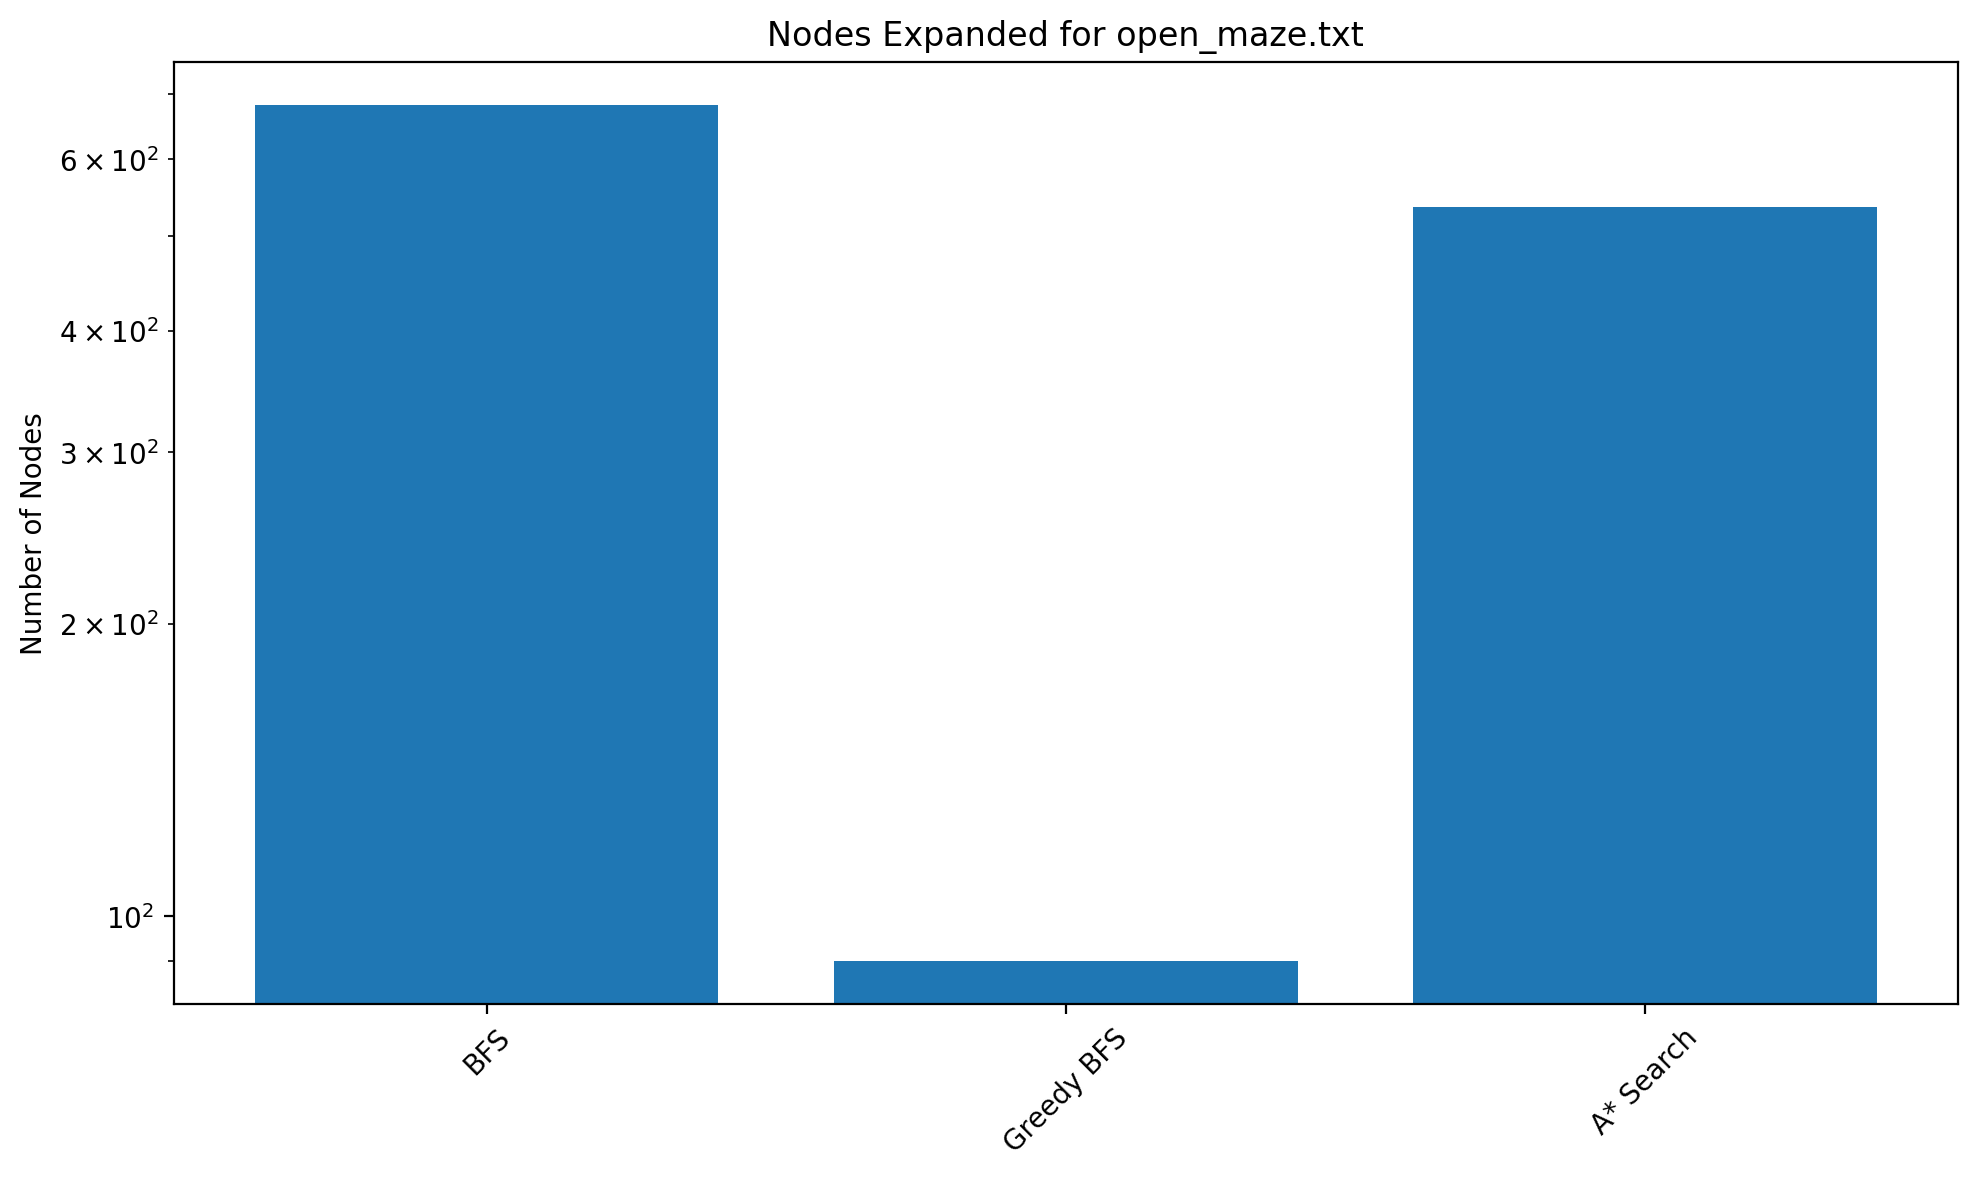

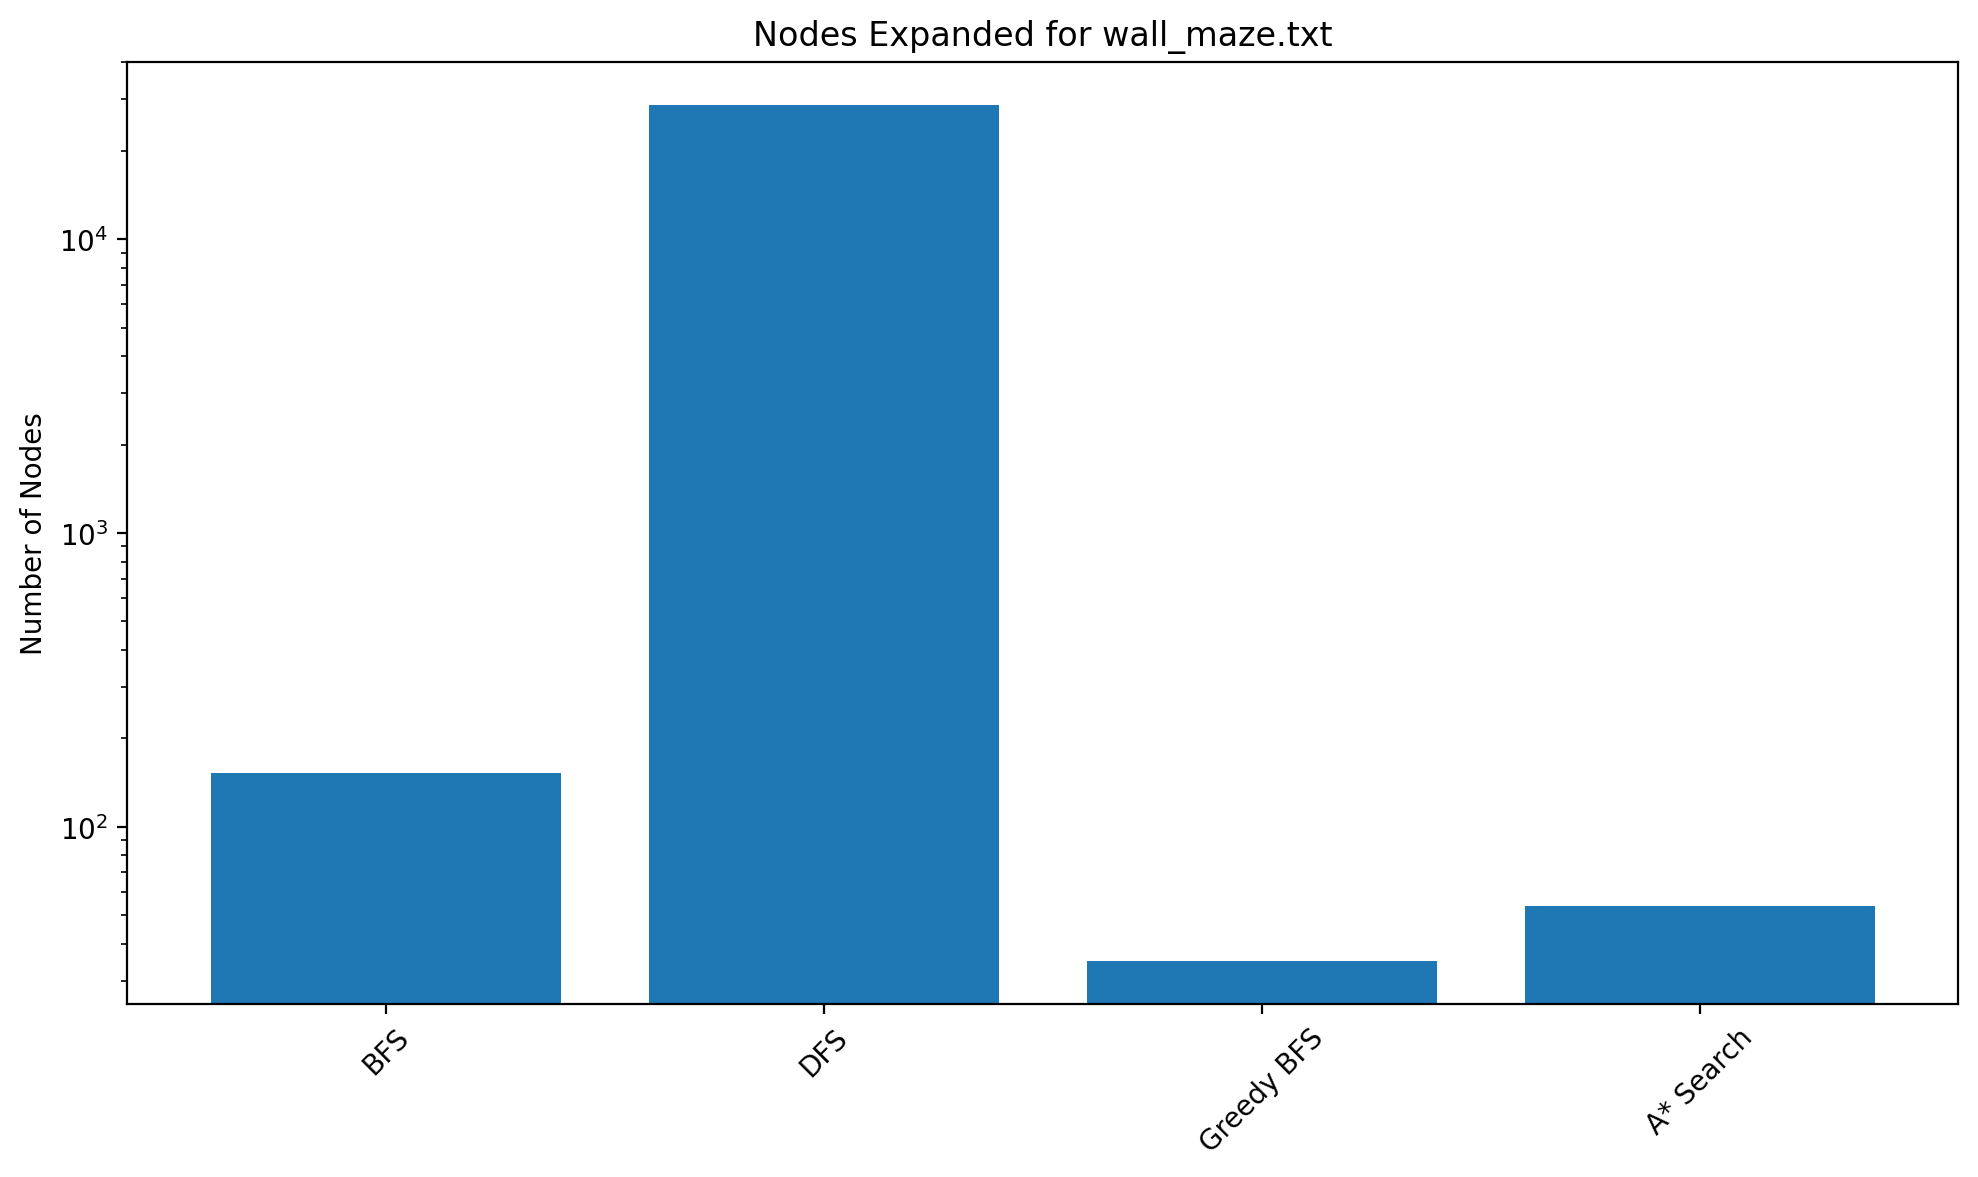

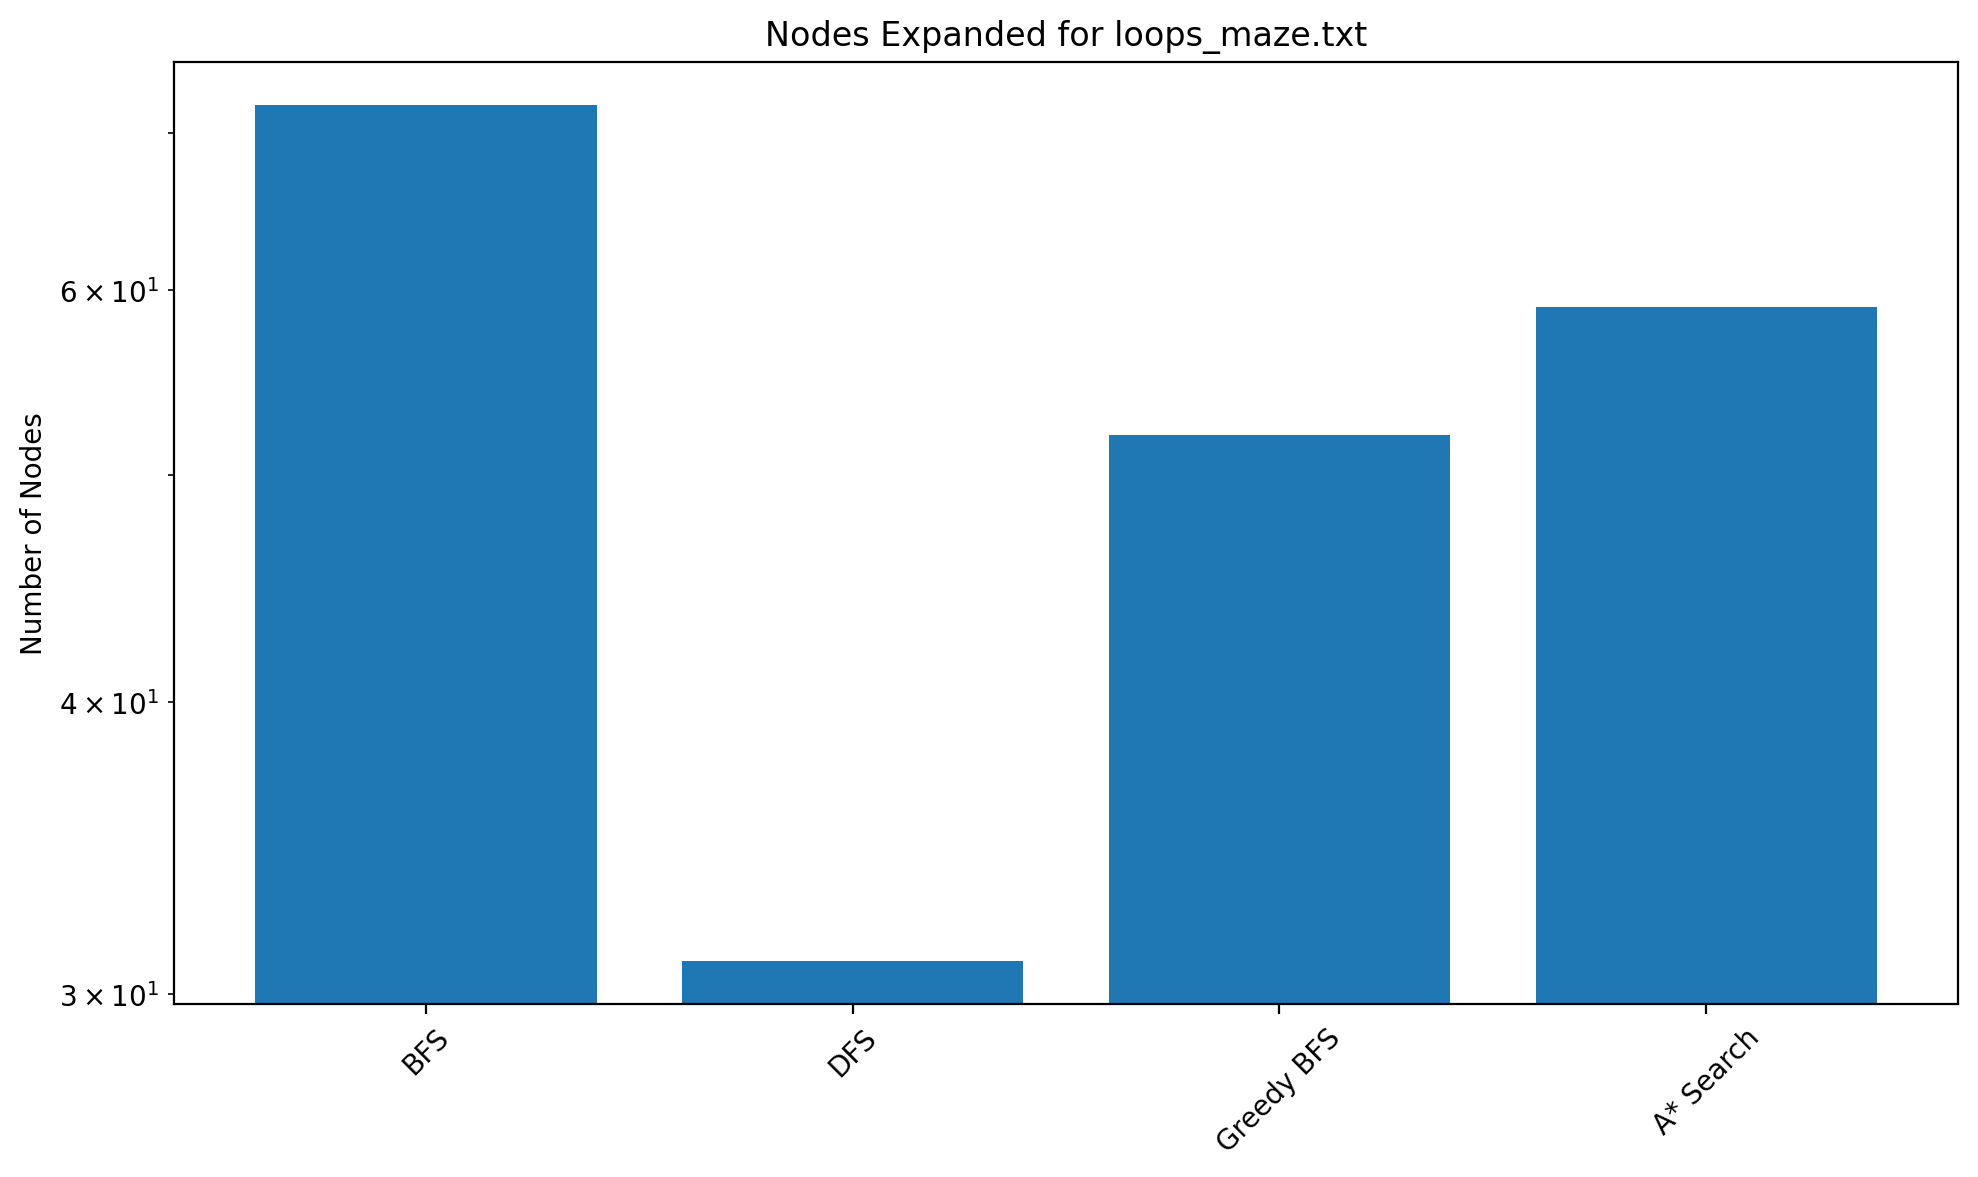

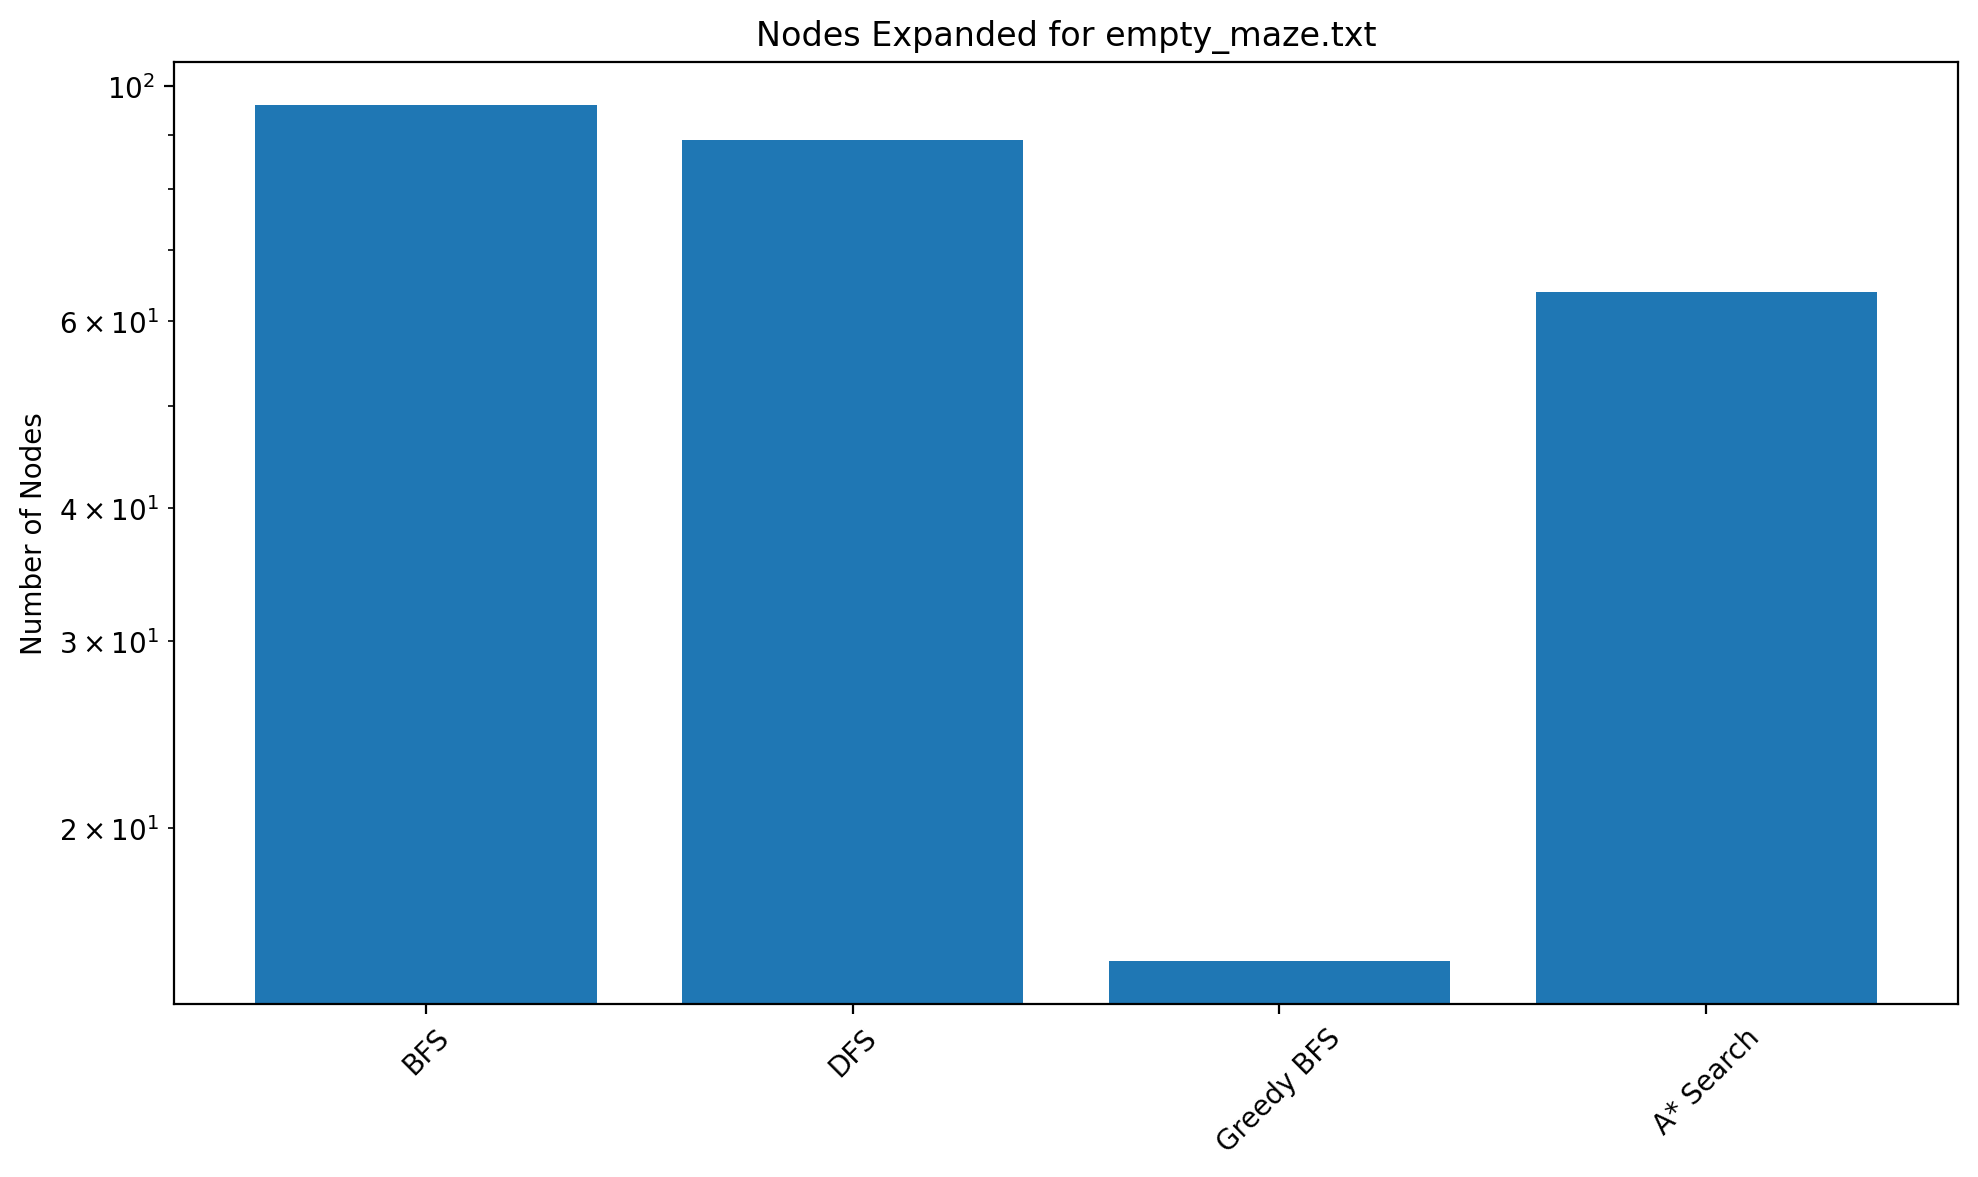

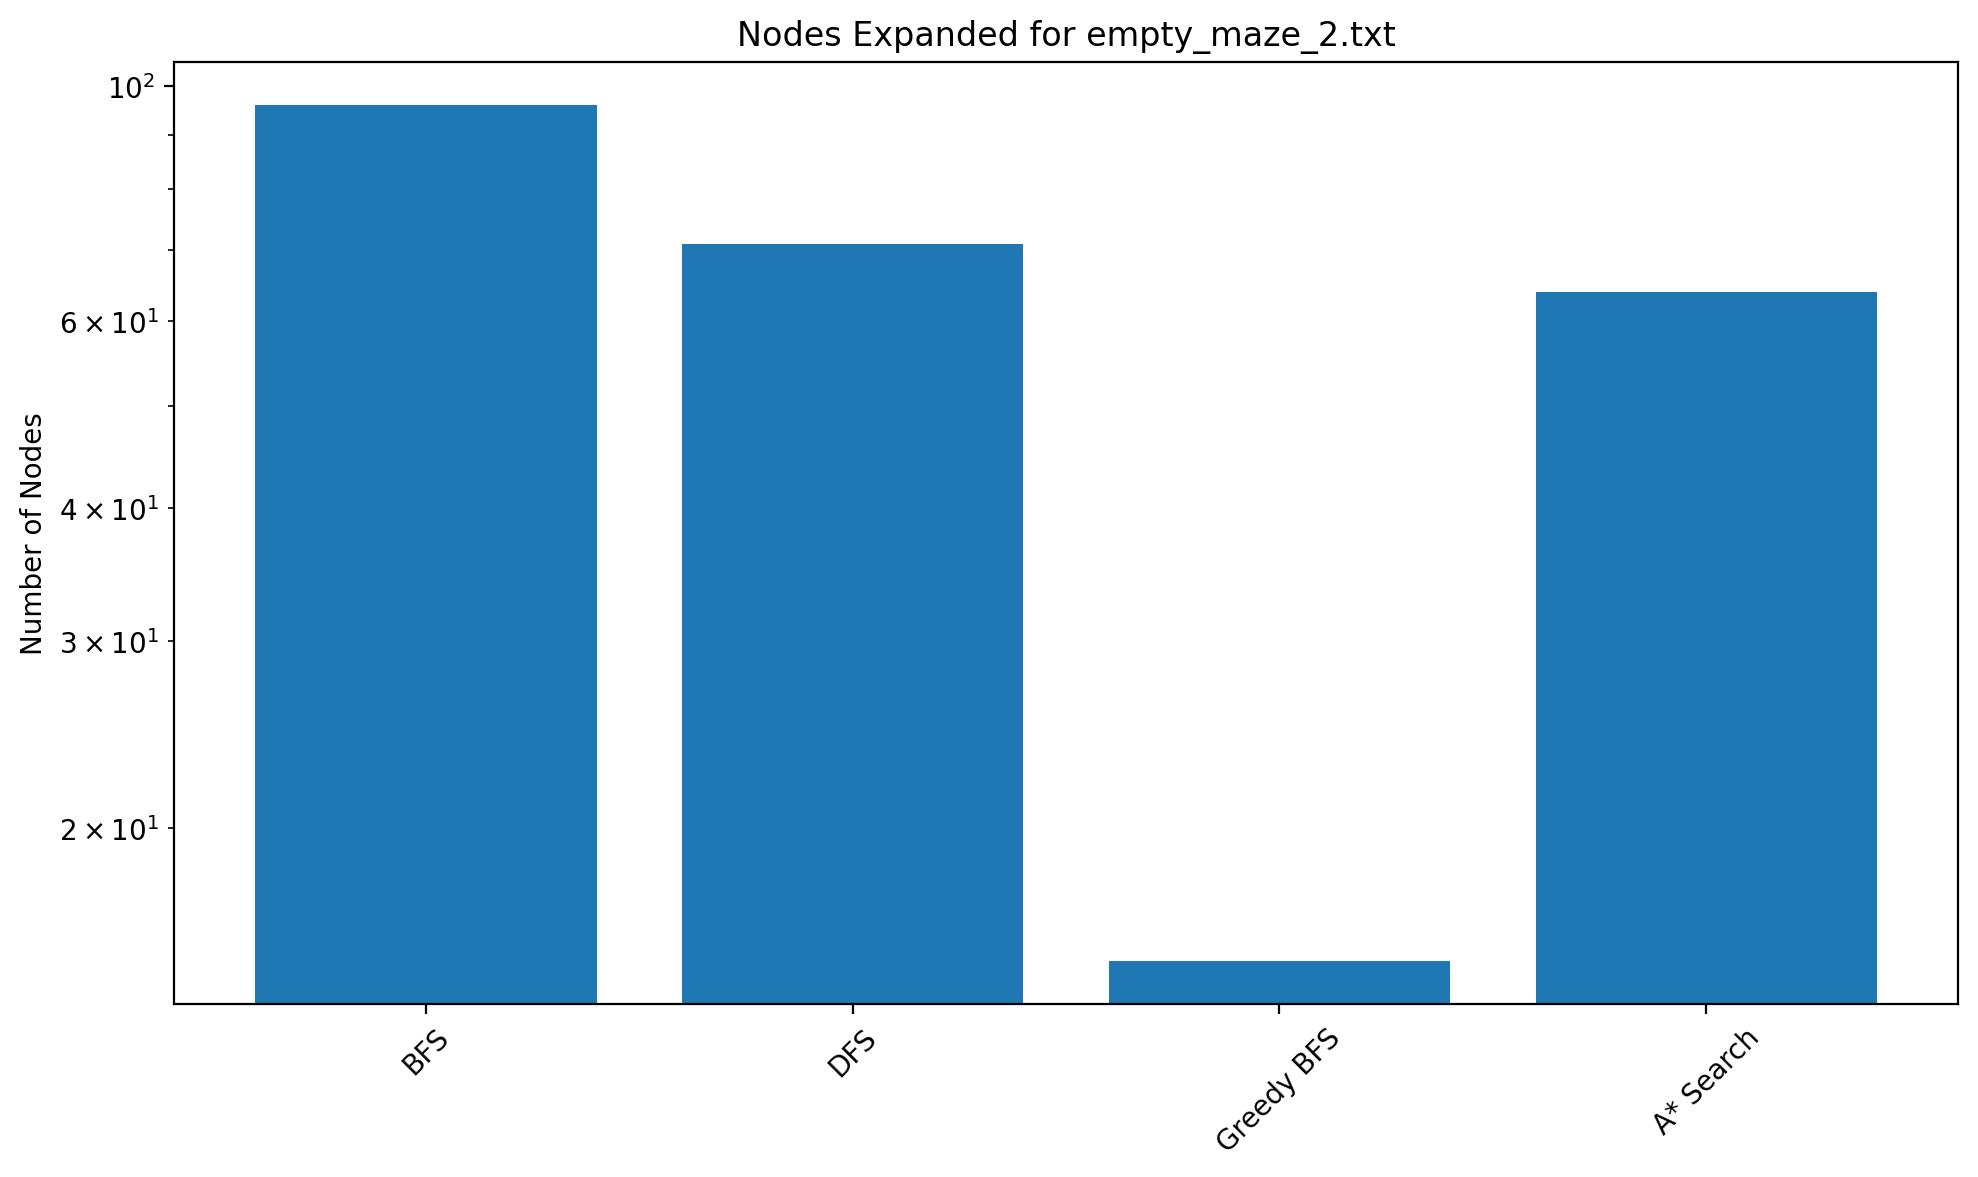

In [ ]:
# Add charts
import matplotlib.pyplot as plt

for maze_name, df in all_results.items():
    df_numeric = df[pd.to_numeric(df['Nodes Expanded'], errors='coerce').notna()]
    if df_numeric.empty:
        continue

    plt.figure(figsize=(10, 6))
    plt.bar(df_numeric['Algorithm'], pd.to_numeric(df_numeric['Nodes Expanded']))
    plt.title(f'Nodes Expanded for {maze_name}')
    plt.ylabel('Number of Nodes')
    plt.yscale('log') # Thang đo log có thể hữu ích cho các giá trị chênh lệch lớn
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Discuss the most important lessons you have learned from implementing the different search strategies.

In [ ]:
# Add discussion

BFS và A* luôn tìm thấy đường đi ngắn nhất (tối ưu).

DFS và Greedy BFS có thể tìm thấy đường đi không tối ưu, đặc biệt trong các mê cung phức tạp hoặc có không gian mở.

A* thường là thuật toán hiệu quả nhất, mở rộng ít nút nhất để tìm ra lời giải tối ưu. Nó kết hợp được ưu điểm của việc đi đúng hướng (nhờ heuristic) và đảm bảo tính tối ưu (nhờ chi phí thực tế).

Greedy BFS có thể rất nhanh nhưng dễ bị "lạc đường" vào các ngõ cụt dài nếu chúng có vẻ gần đích.

DFS có ưu thế lớn về bộ nhớ, nhưng thời gian tìm kiếm có thể rất lâu nếu nó đi sai nhánh từ đầu.

Trên các mê cung đơn giản hoặc không gian mở, sự khác biệt về hiệu suất không quá lớn, nhưng trên các mê cung lớn và phức tạp, A* vượt trội hơn hẳn.



## Advanced task: IDS and Multiple goals

* __Graduate students__ need to complete this task [10 points]
* __Undergraduate students__ can attempt this as a bonus task [max +5 bonus points].

### IDS
Implement IDS (iterative deepening search) using your DFS implementation. Test IDS on the mazes above. You may run into some issues with mazes with open spaces. If you cannot resolve the issues, then report and discuss what causes the problems.

--- Solving: small_maze.txt ---

Solution for IDS:


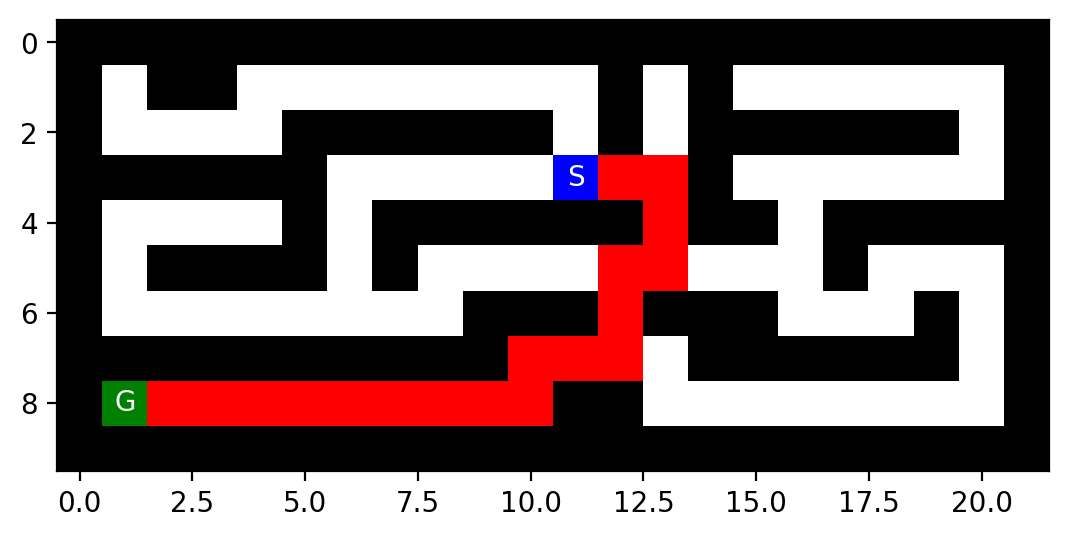

--- Solving: medium_maze.txt ---

Solution for IDS:


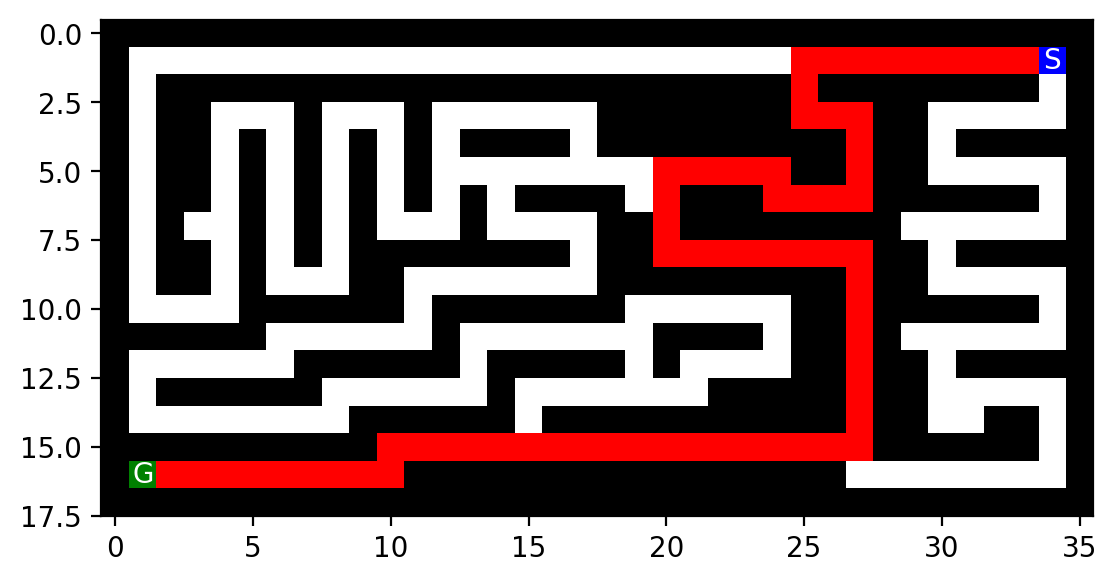

--- Solving: large_maze.txt ---

Solution for IDS:


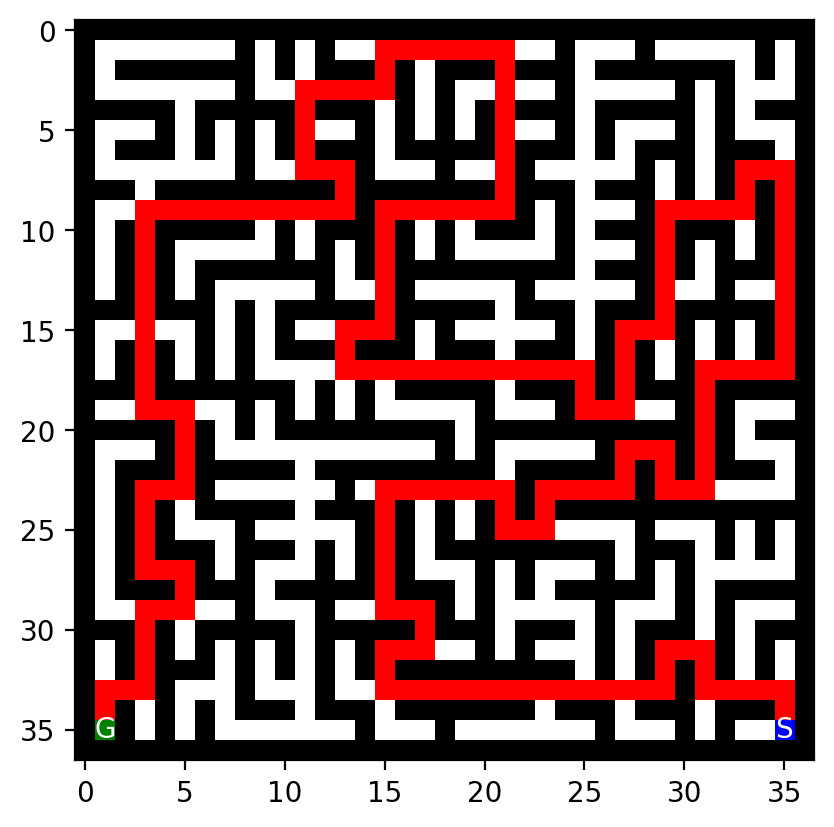

--- Solving: open_maze.txt ---

Solution for IDS: Không tìm thấy lời giải (timeout).
--- Solving: wall_maze.txt ---

Solution for IDS:


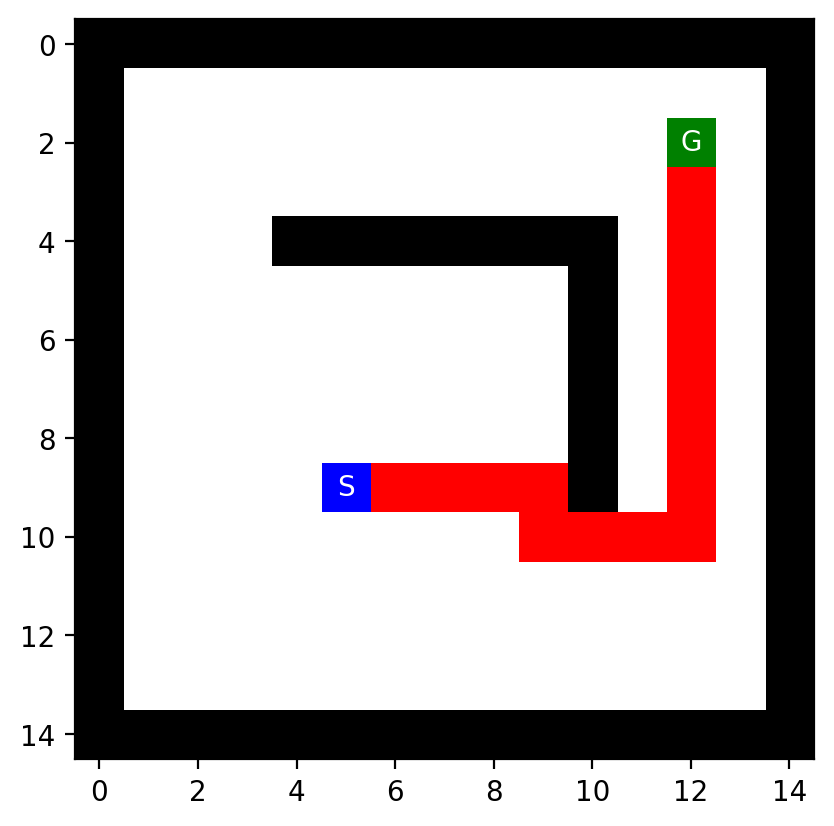

--- Solving: loops_maze.txt ---

Solution for IDS:


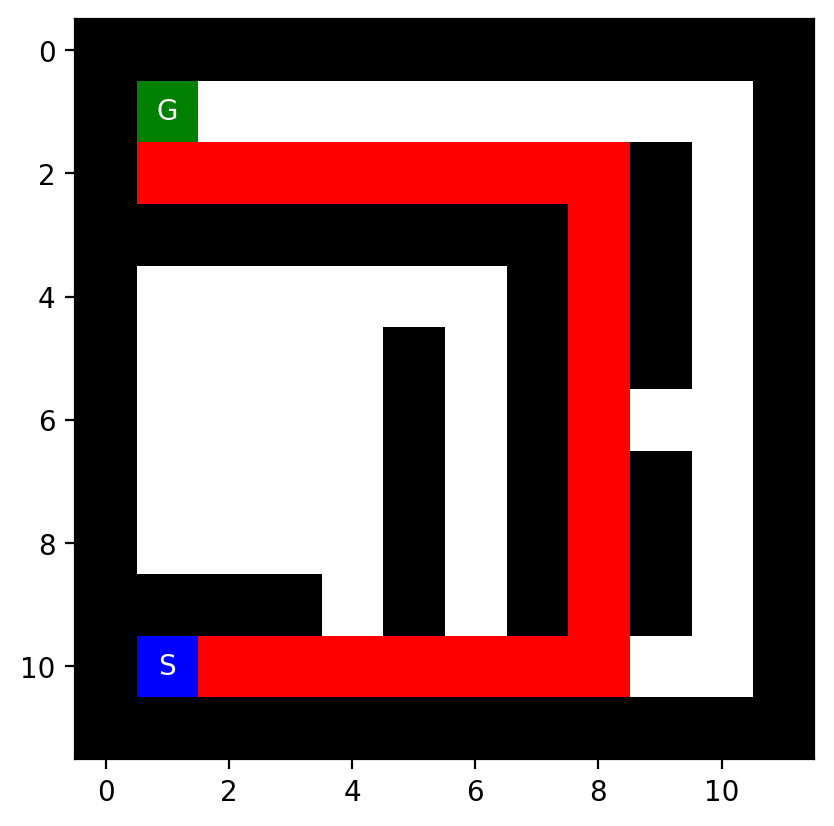

--- Solving: empty_maze.txt ---

Solution for IDS:


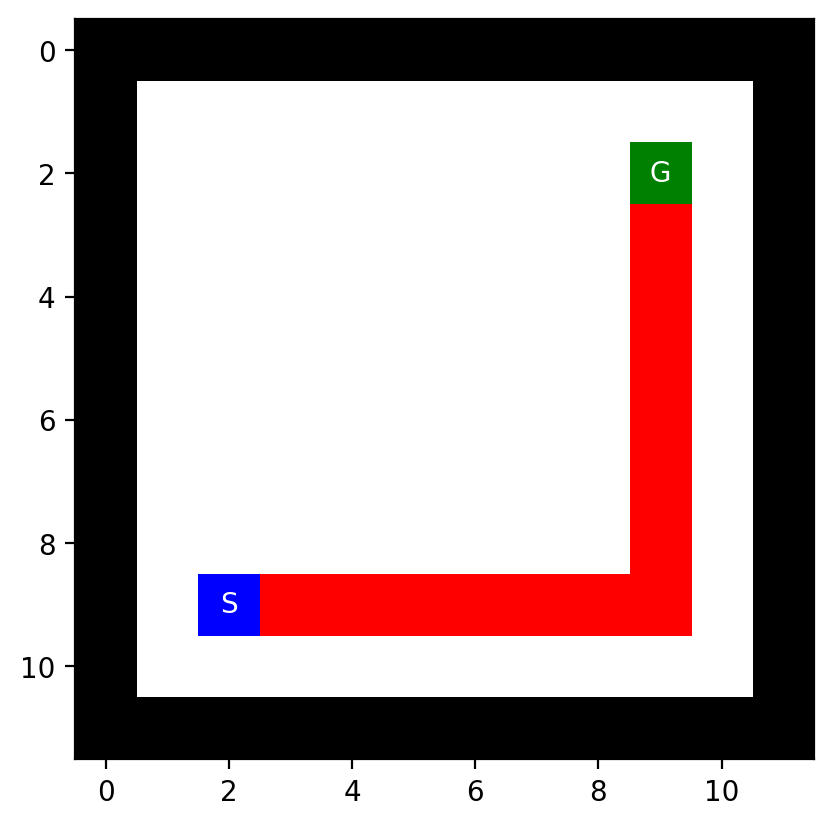

--- Solving: empty_maze_2.txt ---

Solution for IDS:


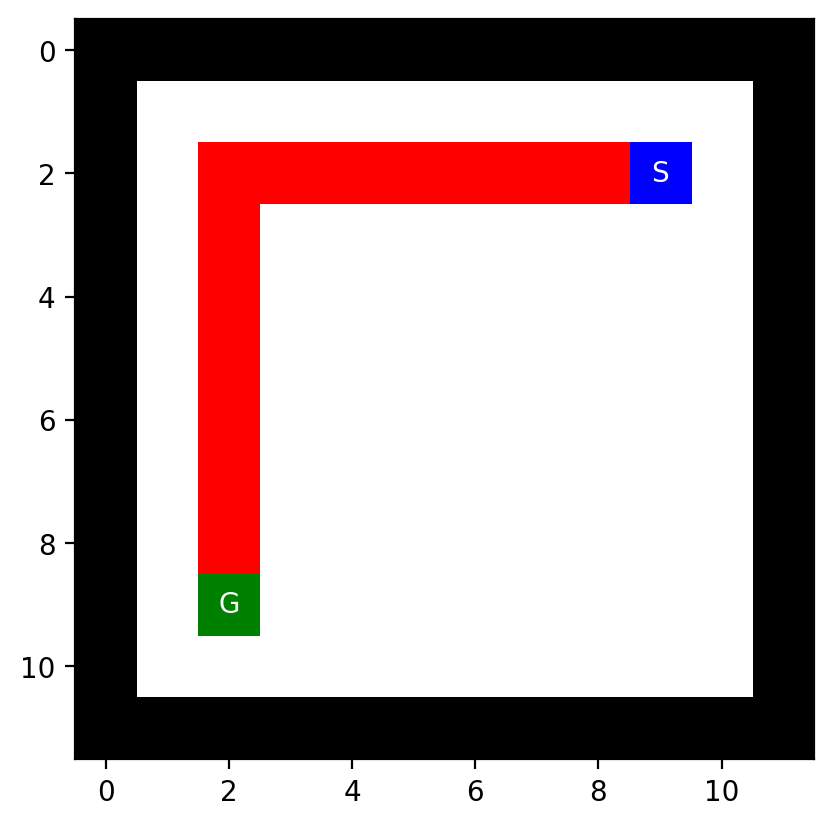


--- Results for small_maze.txt ---


,Algorithm,Path Cost,Nodes Expanded,Max Tree Depth,Max Frontier Size,Max Nodes in Memory,Time
0,IDS,19,1057,19,6,80,0.0085s



--- Results for medium_maze.txt ---


,Algorithm,Path Cost,Nodes Expanded,Max Tree Depth,Max Frontier Size,Max Nodes in Memory,Time
0,IDS,68,16471,68,8,276,0.1941s



--- Results for large_maze.txt ---


,Algorithm,Path Cost,Nodes Expanded,Max Tree Depth,Max Frontier Size,Max Nodes in Memory,Time
0,IDS,210,60830,210,39,844,0.9527s



--- Results for open_maze.txt ---


,Algorithm,Path Cost,Nodes Expanded,Max Tree Depth,Max Frontier Size,Max Nodes in Memory,Time
0,IDS,N/A,N/A,N/A,N/A,N/A,47.7648s



--- Results for wall_maze.txt ---


,Algorithm,Path Cost,Nodes Expanded,Max Tree Depth,Max Frontier Size,Max Nodes in Memory,Time
0,IDS,16,4426930,16,28,68,20.7350s



--- Results for loops_maze.txt ---


,Algorithm,Path Cost,Nodes Expanded,Max Tree Depth,Max Frontier Size,Max Nodes in Memory,Time
0,IDS,23,78925,23,14,96,0.5863s



--- Results for empty_maze.txt ---


,Algorithm,Path Cost,Nodes Expanded,Max Tree Depth,Max Frontier Size,Max Nodes in Memory,Time
0,IDS,14,511704,14,25,60,1.9712s



--- Results for empty_maze_2.txt ---


,Algorithm,Path Cost,Nodes Expanded,Max Tree Depth,Max Frontier Size,Max Nodes in Memory,Time
0,IDS,14,601270,14,26,60,3.4744s


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [ ]:
# Your code/answer goes here
def depth_limited_search(maze, limit, timeout=None):
    start_pos = mh.find_pos(maze, 'S')
    goal_pos = mh.find_pos(maze, 'G')
    start_time = time.time()

    start_node = Node(pos=start_pos, parent=None, action=None, cost=0)
    frontier = [start_node]

    nodes_expanded = 0
    max_frontier_size = 1

    while frontier:
        if timeout and (time.time() - start_time) > timeout:
            return None
        max_frontier_size = max(max_frontier_size, len(frontier))
        node = frontier.pop()
        nodes_expanded += 1

        if node.pos == goal_pos:
            return {
                "solution_node": node,
                "nodes_expanded": nodes_expanded,
                "max_frontier_size": max_frontier_size,
                "cutoff": False
            }

        if node.cost >= limit:
            continue # Dừng nhánh này

        path_to_current = {n.pos for n in node.get_path_from_root()}

        for action, pos in get_neighbors(maze, node.pos):
            if pos not in path_to_current:
                child = Node(pos=pos, parent=node, action=action, cost=node.cost + 1)
                frontier.append(child)

    return {"cutoff": True, "nodes_expanded": nodes_expanded, "max_frontier_size": max_frontier_size}


def iterative_deepening_search(maze, timeout=None):
    """Sử dụng thuật toán tìm kiếm sâu dần (IDS)."""
    total_nodes_expanded = 0
    total_max_frontier = 0
    start_time = time.time()

    for depth in range(maze.size): # Giới hạn độ sâu tối đa là tổng số ô
        if timeout and (time.time() - start_time) > timeout:
            return None

        result = depth_limited_search(maze, depth, timeout=timeout)

        if result is None:
            return None

        total_nodes_expanded += result.get('nodes_expanded', 0)
        total_max_frontier = max(total_max_frontier, result.get('max_frontier_size', 0))

        if not result.get("cutoff"):
            if result.get("solution_node"):
                solution_node = result['solution_node']
                return {
                    "solution_node": solution_node,
                    "nodes_expanded": total_nodes_expanded,
                    "max_tree_depth": solution_node.cost,
                    "max_frontier_size": total_max_frontier,
                    # Không gian bộ nhớ của IDS tương tự DFS, tỉ lệ với độ sâu
                    "max_nodes_in_memory": (solution_node.cost + 1) * 4
                }
    return None

# Add code

def solve_and_report(maze_files, algorithms, timeout=30):
    results = {}
    for file in maze_files:
        print(f"--- Solving: {file} ---")
        with open(file, "r") as f:
            maze = mh.parse_maze(f.read())

        maze_results = []
        for name, func in algorithms.items():
            start_time = time.time()
            if name == "IDS":
                result = func(maze, timeout=timeout)
            duration = time.time() - start_time

            if result:
                solution_node = result['solution_node']
                path_cost = solution_node.cost
                nodes_expanded = result['nodes_expanded']
                max_depth = result['max_tree_depth']
                max_frontier = result['max_frontier_size']
                max_memory = result['max_nodes_in_memory']

                maze_results.append([name, path_cost, nodes_expanded, max_depth, max_frontier, max_memory, f"{duration:.4f}s"])

                # Visualize
                path_nodes = solution_node.get_path_from_root()
                maze_viz = np.copy(maze)
                for node in path_nodes:
                    if maze_viz[node.pos] == ' ':
                        maze_viz[node.pos] = 'P'
                print(f"\nSolution for {name}:")
                mh.show_maze(maze_viz)

            else:
                maze_results.append([name, "N/A", "N/A", "N/A", "N/A", "N/A", f"{duration:.4f}s"])
                print(f"\nSolution for {name}: Không tìm thấy lời giải (timeout).")

        df = pd.DataFrame(maze_results, columns=["Algorithm", "Path Cost", "Nodes Expanded", "Max Tree Depth", "Max Frontier Size", "Max Nodes in Memory", "Time"])
        results[file] = df

    return results

maze_files = ["small_maze.txt", "medium_maze.txt", "large_maze.txt",
              "open_maze.txt", "wall_maze.txt", "loops_maze.txt",
              "empty_maze.txt", "empty_maze_2.txt"]

algorithms = {
    "IDS": iterative_deepening_search
}

all_results = solve_and_report(maze_files, algorithms)

for maze_name, df in all_results.items():
    print(f"\n--- Results for {maze_name} ---")
    display(df)

%time

### Multiple Goals
Create a few mazes with multiple goals by adding one or two more goals to the medium size maze. The agent is done when it finds one of the goals.
Solve the maze with your implementations for DFS, BFS, and IDS. Run experiments to show which implementations find the optimal solution and which do not. Discuss why that is the case.

In [ ]:
# Your code/answer goes here

def depth_limited_search(maze, limit):
    start_pos = mh.find_pos(maze, 'S')
    goal_pos = mh.find_pos(maze, 'G')

    start_node = Node(pos=start_pos, parent=None, action=None, cost=0)
    frontier = [start_node]

    nodes_expanded = 0
    max_frontier_size = 1

    while frontier:
        max_frontier_size = max(max_frontier_size, len(frontier))
        node = frontier.pop()
        nodes_expanded += 1

        if node.pos in set_of_goal_positions:
            return {
                "solution_node": node,
                "nodes_expanded": nodes_expanded,
                "max_frontier_size": max_frontier_size,
                "cutoff": False
            }

        if node.cost >= limit:
            continue # Dừng nhánh này

        path_to_current = {n.pos for n in node.get_path_from_root()}

        for action, pos in get_neighbors(maze, node.pos):
            if pos not in path_to_current:
                child = Node(pos=pos, parent=node, action=action, cost=node.cost + 1)
                frontier.append(child)

    return {"cutoff": True, "nodes_expanded": nodes_expanded, "max_frontier_size": max_frontier_size}


def iterative_deepening_search_update(maze):
    """Sử dụng thuật toán tìm kiếm sâu dần (IDS)."""
    total_nodes_expanded = 0
    total_max_frontier = 0

    for depth in range(maze.size): # Giới hạn độ sâu tối đa là tổng số ô
        result = depth_limited_search(maze, depth)

        total_nodes_expanded += result.get('nodes_expanded', 0)
        total_max_frontier = max(total_max_frontier, result.get('max_frontier_size', 0))

        if not result.get("cutoff"):
            if result.get("solution_node"):
                solution_node = result['solution_node']
                return {
                    "solution_node": solution_node,
                    "nodes_expanded": total_nodes_expanded,
                    "max_tree_depth": solution_node.cost,
                    "max_frontier_size": total_max_frontier,
                    # Không gian bộ nhớ của IDS tương tự DFS, tỉ lệ với độ sâu
                    "max_nodes_in_memory": (solution_node.cost + 1) * 4
                }
    return None

## More Advanced Problems to Think About (not for credit)

If the assignment was to easy for yuo then you can think about the following problems. These problems are challenging and not part of this assignment.

### Intersection as States
Instead of defining each square as a state, use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length measured as the number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

In [ ]:
# Your code/answer goes here

### Weighted A* search
Modify your A* search to add weights (see text book) and explore how different weights influence the result.

In [ ]:
# Your code/answer goes here

def weighted_astar_search(problem, weight):
    # frontier is a priority queue
    frontier = []
    # (total_cost, node)
    heapq.heappush(frontier, (0, Node(problem.get_start_state())))
    reached = {problem.get_start_state(): 0}
    explored_nodes = 0

    goal = problem.goal_nodes[0]

    while frontier:
        explored_nodes += 1
        _, node = heapq.heappop(frontier)
        state = node.state

        if problem.is_goal_state(state):
            return {
                'path': node.get_path(),
                'path_cost': node.path_cost,
                'reached': len(reached),
                'explored_nodes': explored_nodes,
                'actions': node.get_actions()
            }

        for next_state, action in problem.get_actions(state):
            cost = node.path_cost + 1
            if next_state not in reached or cost < reached[next_state]:
                reached[next_state] = cost
                heuristic_cost = manhattan_heuristic(next_state, goal)
                # Apply weight here
                total_cost = cost + weight * heuristic_cost
                child_node = Node(next_state, node, action, cost)
                heapq.heappush(frontier, (total_cost, child_node))
    return None

### Unknown Maze
What happens if the agent does not know the layout of the maze in advance? This means that the agent faces an unknown environment, where it does not know the transition function. How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

In [ ]:
# Your code/answer goes here